In [1]:
#Copied from Aaron's code @ https://github.com/aaronw5/Interpreting-Transformers-for-Jet-Tagging
# Update if repo changes

In [2]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
#from weaver.nn.model.ParticleTransformer import ParticleTransformer
#from weaver.utils.logger import _logger
import torch.optim as optim
#from EfficientParticleTransformer import EfficientParticleTransformer
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [3]:
#!pip install mplhep

In [3]:
import mplhep as hep

hep.style.use(hep.style.ROOT)

In [4]:
def build_features_and_labels(tree, transform_features=True):

    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)

    return out

def build_features_and_labels_jck(tree, transform_features=True):
    """Build features for JetClass dataset based on JetClass_kin.yaml"""
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])

    # apply standardization based on JetClass_kin.yaml
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    # Feature list for JetClass_kin 
    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'],
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel', 
            'part_logerel',
            'part_deltaR',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    def _pad(a, maxlen=128, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    # Labels for JetClass 
    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)

    return out

def build_features_and_labels_jck_pid(tree, transform_features=True):
    """Build features for JetClass dataset based on JetClass_kin.yaml"""
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])

    # apply standardization based on JetClass_kin.yaml
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    # Feature list for JetClass_kinpid
    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'],
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel', 
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    def _pad(a, maxlen=128, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    # Labels for JetClass 
    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)

    return out

In [5]:
#!pip install 'weaver-core>=0.4'

In [9]:
#!pip install fastjet

In [6]:
''' Particle Transformer (ParT)

Paper: "Particle Transformer for Jet Tagging" - https://arxiv.org/abs/2202.03772
'''
import math
import random
import warnings
import copy
import torch
import torch.nn as nn
from functools import partial

from typing import Dict, Optional, Tuple
#from fairseq import utils
#from fairseq.incremental_decoding_utils import with_incremental_state
#from fairseq.modules.quant_noise import quant_noise
from torch import Tensor, nn
from torch.nn import Parameter
from weaver.utils.logger import _logger
import torch.nn.functional as F



@torch.jit.script
def delta_phi(a, b):
    return (a - b + math.pi) % (2 * math.pi) - math.pi


@torch.jit.script
def delta_r2(eta1, phi1, eta2, phi2):
    return (eta1 - eta2)**2 + delta_phi(phi1, phi2)**2


def to_pt2(x, eps=1e-8):
    pt2 = x[:, :2].square().sum(dim=1, keepdim=True)
    if eps is not None:
        pt2 = pt2.clamp(min=eps)
    return pt2


def to_m2(x, eps=1e-8):
    m2 = x[:, 3:4].square() - x[:, :3].square().sum(dim=1, keepdim=True)
    if eps is not None:
        m2 = m2.clamp(min=eps)
    return m2


def atan2(y, x):
    sx = torch.sign(x)
    sy = torch.sign(y)
    pi_part = (sy + sx * (sy ** 2 - 1)) * (sx - 1) * (-math.pi / 2)
    atan_part = torch.arctan(y / (x + (1 - sx ** 2))) * sx ** 2
    return atan_part + pi_part


def to_ptrapphim(x, return_mass=True, eps=1e-8, for_onnx=False):
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    px, py, pz, energy = x.split((1, 1, 1, 1), dim=1)
    pt = torch.sqrt(to_pt2(x, eps=eps))
    # rapidity = 0.5 * torch.log((energy + pz) / (energy - pz))
    rapidity = 0.5 * torch.log(1 + (2 * pz) / (energy - pz).clamp(min=1e-20))
    phi = (atan2 if for_onnx else torch.atan2)(py, px)
    if not return_mass:
        return torch.cat((pt, rapidity, phi), dim=1)
    else:
        m = torch.sqrt(to_m2(x, eps=eps))
        return torch.cat((pt, rapidity, phi, m), dim=1)


def boost(x, boostp4, eps=1e-8):
    # boost x to the rest frame of boostp4
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    p3 = -boostp4[:, :3] / boostp4[:, 3:].clamp(min=eps)
    b2 = p3.square().sum(dim=1, keepdim=True)
    gamma = (1 - b2).clamp(min=eps)**(-0.5)
    gamma2 = (gamma - 1) / b2
    gamma2.masked_fill_(b2 == 0, 0)
    bp = (x[:, :3] * p3).sum(dim=1, keepdim=True)
    v = x[:, :3] + gamma2 * bp * p3 + x[:, 3:] * gamma * p3
    return v


def p3_norm(p, eps=1e-8):
    return p[:, :3] / p[:, :3].norm(dim=1, keepdim=True).clamp(min=eps)


def pairwise_lv_fts(xi, xj, num_outputs=4, eps=1e-8, for_onnx=False):
    pti, rapi, phii = to_ptrapphim(xi, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)
    ptj, rapj, phij = to_ptrapphim(xj, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)

    delta = delta_r2(rapi, phii, rapj, phij).sqrt()
    lndelta = torch.log(delta.clamp(min=eps))
    if num_outputs == 1:
        return lndelta

    if num_outputs > 1:
        ptmin = ((pti <= ptj) * pti + (pti > ptj) * ptj) if for_onnx else torch.minimum(pti, ptj)
        lnkt = torch.log((ptmin * delta).clamp(min=eps))
        lnz = torch.log((ptmin / (pti + ptj).clamp(min=eps)).clamp(min=eps))
        outputs = [lnkt, lnz, lndelta]

    if num_outputs > 3:
        xij = xi + xj
        lnm2 = torch.log(to_m2(xij, eps=eps))
        outputs.append(lnm2)

    if num_outputs > 4:
        lnds2 = torch.log(torch.clamp(-to_m2(xi - xj, eps=None), min=eps))
        outputs.append(lnds2)

    # the following features are not symmetric for (i, j)
    if num_outputs > 5:
        xj_boost = boost(xj, xij)
        costheta = (p3_norm(xj_boost, eps=eps) * p3_norm(xij, eps=eps)).sum(dim=1, keepdim=True)
        outputs.append(costheta)

    if num_outputs > 6:
        deltarap = rapi - rapj
        deltaphi = delta_phi(phii, phij)
        outputs += [deltarap, deltaphi]

    assert (len(outputs) == num_outputs)
    return torch.cat(outputs, dim=1)


def build_sparse_tensor(uu, idx, seq_len):
    # inputs: uu (N, C, num_pairs), idx (N, 2, num_pairs)
    # return: (N, C, seq_len, seq_len)
    batch_size, num_fts, num_pairs = uu.size()
    idx = torch.min(idx, torch.ones_like(idx) * seq_len)
    i = torch.cat((
        torch.arange(0, batch_size, device=uu.device).repeat_interleave(num_fts * num_pairs).unsqueeze(0),
        torch.arange(0, num_fts, device=uu.device).repeat_interleave(num_pairs).repeat(batch_size).unsqueeze(0),
        idx[:, :1, :].expand_as(uu).flatten().unsqueeze(0),
        idx[:, 1:, :].expand_as(uu).flatten().unsqueeze(0),
    ), dim=0)
    return torch.sparse_coo_tensor(
        i, uu.flatten(),
        size=(batch_size, num_fts, seq_len + 1, seq_len + 1),
        device=uu.device).to_dense()[:, :, :seq_len, :seq_len]


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From https://github.com/rwightman/pytorch-image-models/blob/18ec173f95aa220af753358bf860b16b6691edb2/timm/layers/weight_init.py#L8
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


class SequenceTrimmer(nn.Module):

    def __init__(self, enabled=False, target=(0.9, 1.02), **kwargs) -> None:
        super().__init__(**kwargs)
        self.enabled = enabled
        self.target = target
        self._counter = 0

    def forward(self, x, v=None, mask=None, uu=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # uu: (N, C', P, P)
        if mask is None:
            mask = torch.ones_like(x[:, :1])
        mask = mask.bool()

        if self.enabled:
            if self._counter < 5:
                self._counter += 1
            else:
                if self.training:
                    q = min(1, random.uniform(*self.target))
                    maxlen = torch.quantile(mask.type_as(x).sum(dim=-1), q).long()
                    rand = torch.rand_like(mask.type_as(x))
                    rand.masked_fill_(~mask, -1)
                    perm = rand.argsort(dim=-1, descending=True)  # (N, 1, P)
                    mask = torch.gather(mask, -1, perm)
                    x = torch.gather(x, -1, perm.expand_as(x))
                    if v is not None:
                        v = torch.gather(v, -1, perm.expand_as(v))
                    if uu is not None:
                        uu = torch.gather(uu, -2, perm.unsqueeze(-1).expand_as(uu))
                        uu = torch.gather(uu, -1, perm.unsqueeze(-2).expand_as(uu))
                else:
                    maxlen = mask.sum(dim=-1).max()
                maxlen = max(maxlen, 1)
                if maxlen < mask.size(-1):
                    mask = mask[:, :, :maxlen]
                    x = x[:, :, :maxlen]
                    if v is not None:
                        v = v[:, :, :maxlen]
                    if uu is not None:
                        uu = uu[:, :, :maxlen, :maxlen]

        return x, v, mask, uu


class Embed(nn.Module):
    def __init__(self, input_dim, dims, normalize_input=True, activation='gelu'):
        super().__init__()

        self.input_bn = nn.BatchNorm1d(input_dim) if normalize_input else None
        module_list = []
        for dim in dims:
            module_list.extend([
                nn.LayerNorm(input_dim),
                nn.Linear(input_dim, dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
            ])
            input_dim = dim
        self.embed = nn.Sequential(*module_list)

    def forward(self, x):
        if self.input_bn is not None:
            # x: (batch, embed_dim, seq_len)
            x = self.input_bn(x)
            x = x.permute(2, 0, 1).contiguous()
        # x: (seq_len, batch, embed_dim)
        return self.embed(x)


class PairEmbed(nn.Module):
    def __init__(
            self, pairwise_lv_dim, pairwise_input_dim, dims,
            remove_self_pair=False, use_pre_activation_pair=True, mode='sum',
            normalize_input=True, activation='gelu', eps=1e-8,
            for_onnx=False):
        super().__init__()

        self.pairwise_lv_dim = pairwise_lv_dim
        self.pairwise_input_dim = pairwise_input_dim
        self.is_symmetric = (pairwise_lv_dim <= 5) and (pairwise_input_dim == 0)
        self.remove_self_pair = remove_self_pair
        self.mode = mode
        self.for_onnx = for_onnx
        self.pairwise_lv_fts = partial(pairwise_lv_fts, num_outputs=pairwise_lv_dim, eps=eps, for_onnx=for_onnx)
        self.out_dim = dims[-1]

        if self.mode == 'concat':
            input_dim = pairwise_lv_dim + pairwise_input_dim
            module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
            for dim in dims:
                module_list.extend([
                    nn.Conv1d(input_dim, dim, 1),
                    nn.BatchNorm1d(dim),
                    nn.GELU() if activation == 'gelu' else nn.ReLU(),
                ])
                input_dim = dim
            if use_pre_activation_pair:
                module_list = module_list[:-1]
            self.embed = nn.Sequential(*module_list)
        elif self.mode == 'sum':
            if pairwise_lv_dim > 0:
                input_dim = pairwise_lv_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.embed = nn.Sequential(*module_list)

            if pairwise_input_dim > 0:
                input_dim = pairwise_input_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.fts_embed = nn.Sequential(*module_list)
        else:
            raise RuntimeError('`mode` can only be `sum` or `concat`')

    def forward(self, x, uu=None):
        # x: (batch, v_dim, seq_len)
        # uu: (batch, v_dim, seq_len, seq_len)
        assert (x is not None or uu is not None)
        with torch.no_grad():
            if x is not None:
                batch_size, _, seq_len = x.size()
            else:
                batch_size, _, seq_len, _ = uu.size()
            if self.is_symmetric and not self.for_onnx:
                i, j = torch.tril_indices(seq_len, seq_len, offset=-1 if self.remove_self_pair else 0,
                                          device=(x if x is not None else uu).device)
                if x is not None:
                    x = x.unsqueeze(-1).repeat(1, 1, 1, seq_len)
                    xi = x[:, :, i, j]  # (batch, dim, seq_len*(seq_len+1)/2)
                    xj = x[:, :, j, i]
                    x = self.pairwise_lv_fts(xi, xj)
                if uu is not None:
                    # (batch, dim, seq_len*(seq_len+1)/2)
                    uu = uu[:, :, i, j]
            else:
                if x is not None:
                    x = self.pairwise_lv_fts(x.unsqueeze(-1), x.unsqueeze(-2))
                    if self.remove_self_pair:
                        i = torch.arange(0, seq_len, device=x.device)
                        x[:, :, i, i] = 0
                    x = x.view(-1, self.pairwise_lv_dim, seq_len * seq_len)
                if uu is not None:
                    uu = uu.view(-1, self.pairwise_input_dim, seq_len * seq_len)
            if self.mode == 'concat':
                if x is None:
                    pair_fts = uu
                elif uu is None:
                    pair_fts = x
                else:
                    pair_fts = torch.cat((x, uu), dim=1)

        if self.mode == 'concat':
            elements = self.embed(pair_fts)  # (batch, embed_dim, num_elements)
        elif self.mode == 'sum':
            if x is None:
                elements = self.fts_embed(uu)
            elif uu is None:
                elements = self.embed(x)
            else:
                elements = self.embed(x) + self.fts_embed(uu)

        if self.is_symmetric and not self.for_onnx:
            y = torch.zeros(batch_size, self.out_dim, seq_len, seq_len, dtype=elements.dtype, device=elements.device)
            y[:, :, i, j] = elements
            y[:, :, j, i] = elements
        else:
            y = elements.view(-1, self.out_dim, seq_len, seq_len)
        return y





class Block(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, ffn_ratio=4,
                 dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                 add_bias_kv=False, activation='gelu',
                 scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.ffn_dim = embed_dim * ffn_ratio
        self.interaction = None
        self.pre_mask_attn_weights = None  # To store attention weights before mask is applied

        self.pre_attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=attn_dropout,
            add_bias_kv=add_bias_kv,
        )
        self.post_attn_norm = nn.LayerNorm(embed_dim) if scale_attn else None
        self.dropout = nn.Dropout(dropout)

        self.pre_fc_norm = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, self.ffn_dim)
        self.act = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.act_dropout = nn.Dropout(activation_dropout)
        self.post_fc_norm = nn.LayerNorm(self.ffn_dim) if scale_fc else None
        self.fc2 = nn.Linear(self.ffn_dim, embed_dim)

        self.c_attn = nn.Parameter(torch.ones(num_heads), requires_grad=True) if scale_heads else None
        self.w_resid = nn.Parameter(torch.ones(embed_dim), requires_grad=True) if scale_resids else None
    def getAttention(self):
        return self.interaction
    def getPreMaskAttention(self):
        return self.pre_mask_attn_weights
    def forward(self, x, x_cls=None, padding_mask=None, attn_mask=None):
        """
        Args:
            x (Tensor): input to the layer of shape (seq_len, batch, embed_dim)
            x_cls (Tensor, optional): class token input to the layer of shape (1, batch, embed_dim)
            padding_mask (ByteTensor, optional): binary
                ByteTensor of shape (batch, seq_len) where padding
                elements are indicated by `1.

        Returns:
            encoded output of shape (seq_len, batch, embed_dim)
        """

        if x_cls is not None:
            with torch.no_grad():
                # prepend one element for x_cls: -> (batch, 1+seq_len)
                padding_mask = torch.cat((torch.zeros_like(padding_mask[:, :1]), padding_mask), dim=1)
            # class attention: https://arxiv.org/pdf/2103.17239.pdf
            residual = x_cls
            u = torch.cat((x_cls, x), dim=0)  # (seq_len+1, batch, embed_dim)
            u = self.pre_attn_norm(u)
            x = self.attn(x_cls, u, u, key_padding_mask=padding_mask)[0]  # (1, batch, embed_dim)
        else:
            residual = x


            x = self.pre_attn_norm(x)


            x= self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask, average_attn_weights=False)[0]  # (seq_len, batch, embed_dim)
            y= self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask, average_attn_weights=False)[1]
            self.interaction = y


        if self.c_attn is not None:
            tgt_len = x.size(0)
            x = x.view(tgt_len, -1, self.num_heads, self.head_dim)
            x = torch.einsum('tbhd,h->tbdh', x, self.c_attn)
            x = x.reshape(tgt_len, -1, self.embed_dim)
        if self.post_attn_norm is not None:
            x = self.post_attn_norm(x)
        x = self.dropout(x)
        x += residual

        residual = x
        x = self.pre_fc_norm(x)
        x = self.act(self.fc1(x))
        x = self.act_dropout(x)
        if self.post_fc_norm is not None:
            x = self.post_fc_norm(x)
        x = self.fc2(x)
        x = self.dropout(x)
        if self.w_resid is not None:
            residual = torch.mul(self.w_resid, residual)
        x += residual

        return x


class ParticleTransformer(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=10,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[64, 64, 64],
                 pair_embed_dims=[32, 32, 32],
                 num_heads=1,
                 num_layers=1,
                 num_cls_layers=1,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.attention_matrix = []
        self.for_inference = for_inference
        self.use_amp = use_amp
        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True)
        self.pairMatrixes = []

        cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        self.blocks = nn.ModuleList([Block(**cfg_block) for _ in range(num_layers)])
        self.cls_blocks = nn.ModuleList([Block(**cfg_cls_block) for _ in range(num_cls_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.interactionMatrix = None

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def getAttention(self):
        return self.attention_matrix

    def getInteraction(self):
        return self.interactionMatrix

    def getPairs(self):
        return self.pairMatrixes


    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            #num = 0
            for block in self.blocks:

                x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask)
                self.interactionMatrix = attn_mask
                #if num == 0 :
                self.attention_matrix.append(block.interaction)
                #num = num + 1

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            if self.for_inference:
                output = torch.softmax(output, dim=1)


            return output

class ParticleTransformerTagger(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = ParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            pf_x, pf_v, pf_mask, _ = self.pf_trimmer(pf_x, pf_v, pf_mask)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask)


class ParticleTransformerTaggerWithExtraPairFeatures(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp
        self.for_inference = for_inference

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = ParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None, pf_uu=None, pf_uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            if not self.for_inference:
                if pf_uu_idx is not None:
                    pf_uu = build_sparse_tensor(pf_uu, pf_uu_idx, pf_x.size(-1))

            pf_x, pf_v, pf_mask, pf_uu = self.pf_trimmer(pf_x, pf_v, pf_mask, pf_uu)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)
            uu = torch.zeros(v.size(0), pf_uu.size(1), v.size(2), v.size(2), dtype=v.dtype, device=v.device)
            uu[:, :, :pf_x.size(2), :pf_x.size(2)] = pf_uu

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask, uu)





In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_attention(detaCH, dphiCH, ptCH, detaNH, dphiNH, ptNH,
                   detaPhoton, dphiPhoton, ptPhoton,
                   detaElectron, dphiElectron, ptElectron,
                   detaMuon, dphiMuon, ptMuon,
                   pt, eta, phi, attention_matrix, layer_number, subjets,
                   plot_single_head=False, head_to_plot=0, show_subjet=None):
    # Check if attention_matrix is a PyTorch tensor and convert it
    if isinstance(attention_matrix, torch.Tensor):
        attention_matrix = attention_matrix.numpy()

    num_heads, n, _ = attention_matrix.shape

    # Determine how many heads to plot
    if plot_single_head:
        heads_to_plot = [head_to_plot]
        fig, axes = plt.subplots(1, 1, figsize=(8, 8))  # Only one plot, single head
        axes = [axes]  # Wrap single axis in a list to maintain consistency
    else:
        heads_to_plot = range(num_heads)
        num_cols = 4
        num_rows = int(np.ceil(len(heads_to_plot) / num_cols))
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 6 * num_rows))
        axes = axes.flatten()

    # Normalize the pt values for color mapping
    norm_pt = mcolors.Normalize(vmin=pt.min(), vmax=pt.max())
    cmap_pt = plt.cm.plasma

    # Normalize the attention values for color mapping
    norm_attn = mcolors.Normalize(vmin=attention_matrix.min(), vmax=attention_matrix.max())
    cmap_attn = plt.cm.Greys

    # Define a list of sequential colormaps for subjets
    colormaps = [
        plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens,
        plt.cm.Reds, plt.cm.Purples, plt.cm.Greys
    ]

    # Ensure we have enough colormaps for the number of subjets
    num_subjets = np.max(subjets) + 1
    assert num_subjets <= len(colormaps), "Not enough colormaps defined for the number of subjets."

    # Assign a distinct colormap to each subjet
    subjet_colors = [colormaps[i % len(colormaps)] for i in range(num_subjets)]

    # Define distinct colors for connection lines between subjets
    from itertools import combinations
    color_palette = list(mcolors.TABLEAU_COLORS.values())[:num_subjets * (num_subjets + 1) // 2]
    connection_colors = {}
    color_idx = 0

    for i in range(num_subjets):
        # Use the primary color of the subjet's colormap for self-connections
        primary_color = subjet_colors[i](0.5)  # Use the midpoint of the colormap
        connection_colors[(i, i)] = primary_color

    for i, j in combinations(range(num_subjets), 2):
        connection_colors[(i, j)] = color_palette[color_idx]
        connection_colors[(j, i)] = color_palette[color_idx]
        color_idx += 1

    # Filter the attention matrix based on the show_subjet
    valid_indices = range(n)
    if show_subjet is not None:
        valid_indices = [i for i in range(n) if subjets[i] == show_subjet]
        attention_matrix_filtered = np.zeros_like(attention_matrix)
        for head in range(num_heads):
            for i in valid_indices:
                for j in range(n):
                    if subjets[j] == show_subjet or subjets[j] != -1:
                        attention_matrix_filtered[head, i, j] = attention_matrix[head, i, j]
                        attention_matrix_filtered[head, j, i] = attention_matrix[head, j, i]
    else:
        attention_matrix_filtered = attention_matrix

    for head_idx, head in enumerate(heads_to_plot):
        ax = axes[head_idx]
        attn = attention_matrix_filtered[head]

        # Gather and sort attention pairs by value
        attention_pairs = [(attn[i, j], i, j) for i in range(n) for j in range(n) if i != j and attn[i, j] > 0]
        attention_pairs.sort()  # Sort by attention value

        # Plot attention lines from lowest to highest value (light to dark)
        for value, i, j in attention_pairs:
            alpha = 1 * norm_attn(value)

            color = connection_colors.get((subjets[i], subjets[j]), 'black')
            if subjets[i] == subjets[j]:
                linestyle = 'solid'
                linewidth = 1.5
            elif show_subjet is not None and (subjets[i] == show_subjet or subjets[j] == show_subjet):
                linestyle = 'dotted'
                linewidth = 1.0
            else:
                linestyle = 'dashed'
                linewidth = 2.5

            ax.plot([eta[i], eta[j]], [phi[i], phi[j]],
                    color=color, alpha=alpha, zorder=1, linewidth=linewidth, linestyle=linestyle)

        # Function to get alpha, size, and edge width based on pt
        def get_properties(index):
            alpha = 0.5 + 0.5 * norm_pt(pt[index])  # Minimum opacity of 0.6
            size = 50 + 150 * norm_pt(pt[index])  # Increase size for higher pt
            edge_width = 0.5 + 2.0 * norm_pt(pt[index])  # Increase edge width for higher pt
            return alpha, size, edge_width

        # Function to plot particles with different shapes
        def plot_particles(deta, dphi, pt_values, marker, label, subjet_indices):
            for i in range(len(deta)):
                alpha, size, edge_width = get_properties(i)
                color = cmap_pt(norm_pt(pt_values[i]))  # Color by pt
                edge_color = subjet_colors[subjet_indices[i]](0.5)  # Edge color by subjet
                ax.scatter(deta[i], dphi[i], c=[color], alpha=alpha, s=size, zorder=3, marker=marker,
                           edgecolors='black', linewidths=edge_width, label=label if i == 0 else "")

        # Scatter plot with color by pt and outline color by subjet
        #plot_particles(detaCH, dphiCH, ptCH, '^', 'Charged Hadron', subjets)
        #plot_particles(detaNH, dphiNH, ptNH, 'v', 'Neutral Hadron', subjets)
        #plot_particles(detaPhoton, dphiPhoton, ptPhoton, 'o', 'Photon', subjets)
        #plot_particles(detaElectron, dphiElectron, ptElectron, 'P', 'Electron', subjets)
        #plot_particles(detaMuon, dphiMuon, ptMuon, 'X', 'Muon', subjets)

        ax.set_title(f'Layer {layer_number}: Head {head + 1}')
        ax.set_xlabel('eta')
        ax.set_ylabel('phi')

    # Remove extra subplots if plotting only one head
    if not plot_single_head:
        for i in range(len(heads_to_plot), num_rows * num_cols):
            fig.delaxes(axes[i])

    fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=3.0)

    # Add colorbars for pt and attention weights
    cbar_pt = fig.colorbar(plt.cm.ScalarMappable(norm=norm_pt, cmap=cmap_pt), ax=axes[:len(heads_to_plot)],
                           shrink=0.6, aspect=20, label='Pt')
    cbar_attn = fig.colorbar(plt.cm.ScalarMappable(norm=norm_attn, cmap=cmap_attn), ax=axes[:len(heads_to_plot)],
                             shrink=0.6, aspect=20, label='Attention Weight', orientation='horizontal', pad=0.05)

    # Add legend for connection colors
    unique_connections = {tuple(sorted((key[0], key[1]))): value for key, value in connection_colors.items()}
    handles_conn = [plt.Line2D([0], [0], color=color, lw=2.5 if i != j else 1.5, linestyle='dashed' if i != j else 'solid') for (i, j), color in unique_connections.items()]
    labels_conn = [f'Connection {i}-{j}' for (i, j) in unique_connections.keys()]
    legend_conn = fig.legend(handles_conn, labels_conn, loc='upper right', title='Connection Colors', fontsize=12, title_fontsize=14)

    # Add legend for particle shapes
    handles_shapes = [plt.Line2D([0], [0], color='k', marker='^', linestyle='', markersize=10, label='Charged Hadron'),
                      plt.Line2D([0], [0], color='k', marker='v', linestyle='', markersize=10, label='Neutral Hadron'),
                      plt.Line2D([0], [0], color='k', marker='o', linestyle='', markersize=10, label='Photon'),
                      plt.Line2D([0], [0], color='k', marker='P', linestyle='', markersize=10, label='Electron'),
                      plt.Line2D([0], [0], color='k', marker='X', linestyle='', markersize=10, label='Muon')]
    legend_shapes = fig.legend(handles_shapes, [handle.get_label() for handle in handles_shapes], loc='lower right', title='Particle Shapes', fontsize=12, title_fontsize=14)

    # Add all legends to the figure
    fig.add_artist(legend_conn)
    fig.add_artist(legend_shapes)

    plt.show()


In [8]:
#!pip install 'weaver-core>=0.4'

In [9]:
label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']


In [8]:
def find_indexes(input_list):
    return [index for index, value in enumerate(input_list) if value == 4]

In [13]:
#pf_features = np.load('/content/drive/MyDrive/networks/SMALLpfFeat.npy')
#pf_vectors = np.load('/content/drive/MyDrive/networks/SMALLpfVectors.npy')
#pf_mask = np.load('/content/drive/MyDrive/networks/SMALLpfMask.npy')
#pf_points = np.load('/content/drive/MyDrive/networks/SMALLpfPoints.npy')
#labels = np.load('/content/drive/MyDrive/networks/SMALLlabels.npy')

#input_list = list(np.argmax(labels,axis=1))
#indexes = find_indexes(input_list)
#print(indexes)

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
jet = 0
head = 0
layer = 0

In [10]:
import torch

class ParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer(**kwargs)
        self.attention_matrix = None
        self.interactionMatrix = None
        self.pre_mask_attention_matrices = []

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        #self.pre_mask_attention_matrices = self.get_pre_mask_attention_matrices()
        return output

    def get_attention_matrix(self):
        return self.attention_matrix

    def get_interactionMatrix(self):
        return self.interactionMatrix




def get_model(model_type='qg',**kwargs):

    if model_type == 'qg':
        # QuarkGluon model configuration (13 kinpid features)
        cfg = dict(
            input_dim=13,  # pt_log, e_log, logptrel, logerel, deltaR, charge, isChargedHadron, isNeutralHadron, isPhoton, isElectron, isMuon, deta, dphi
            num_classes=2,  # Quark vs Gluon
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'tl':
        # TopLandscape model configuration (7 kinematic features)
        cfg = dict(
            input_dim=7,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi
            num_classes=2,  # Top vs QCD
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'jck':
        # JetClass kin model configuration (7 kinematic features)
        cfg = dict(
            input_dim=7,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi
            num_classes=10,
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'jck_pid':
        # JetClass kin model configuration (7 kinematic features)
        cfg = dict(
            input_dim=13,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi along with PID features
            num_classes=10,
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    else:
        print(f"Defaulting to Jet_Class-trained model configuration")
        cfg = dict(
            input_dim=7,
            num_classes=10,
            # network configurations
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            # misc
            trim=True,
            for_inference=False,
        )
    
    cfg.update(**kwargs)
    model = ParticleTransformerWrapper(**cfg)

    model_info = {

    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [12]:
def load_data(dataset_type='qg', filepath='qg_test_file_0.root', batch_size=300):
    """
    Load test data from given .root file and format to dict
    Args: dataset type (QuarkGluon, TopLandscape, JetClass, HLS4ML) and batch size
    """
    try:
        if dataset_type == 'qg':
            # Try to load QuarkGluon data
            data_path = filepath
            if os.path.exists(data_path):
                print(f"Loading actual QuarkGluon data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - QG')
                    data = build_features_and_labels(tree)
                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size], 
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            'labels': data['label'][:batch_size]
                        }
                    return data

        elif dataset_type == 'tl':
            # Try to load TopLandscape data
            data_path = filepath
            if os.path.exists(data_path):
                print(f"Loading actual TopLandscape data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - TL')
                    data = build_features_and_labels(tree)
                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size],
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            'labels': data['label'][:batch_size]
                        }
                    return data

        elif dataset_type == 'jck':
            # Try to load JetClass data
            data_path = filepath
            if os.path.exists(data_path):
                print(f"Loading actual JetClass data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - JCK')
                    data = build_features_and_labels_jck(tree)
                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size],
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            'labels': data['label'][:batch_size]
                        }
                    return data

        elif dataset_type == 'jck_pid':
            # Try to load JetClass data w/ PIDs
            data_path = filepath
            if os.path.exists(data_path):
                print(f"Loading actual JetClass data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - JCK')
                    data = build_features_and_labels_jck_pid(tree)
                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size],
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            'labels': data['label'][:batch_size]
                        }
                    return data

    except Exception as e:
        print(f"Could not load actual data: {e}")
        raise e

In [13]:

# Create sample data for HToWW2Q1L decay
print("Creating sample data for testing...")
jck_data = load_data(dataset_type='jck', filepath='/mnt/c/Interpretability_Data/JetClass/test_20M/HToWW2Q1L_100.root', batch_size=300)

print(f"Sampled data shapes:")
for k, v in jck_data.items():
    print(f"  {k}: {v.shape}")

print(f"\nFeature dimensions:")
print(f"  JetClass (kin): {jck_data['pf_features'].shape[1]} features")

Creating sample data for testing...
Loading actual JetClass data from /mnt/c/Interpretability_Data/JetClass/test_20M/HToWW2Q1L_100.root
This part is working - JCK
Truncating from 100000 jets to 300 jets
Sampled data shapes:
  pf_points: (300, 2, 128)
  pf_features: (300, 7, 128)
  pf_vectors: (300, 4, 128)
  pf_mask: (300, 1, 128)
  labels: (300, 10)

Feature dimensions:
  JetClass (kin): 7 features


In [14]:
#check the feature names in jck
print("\nFeature names:")
print("  JetClass (kin):", jck_data['pf_features'])


Feature names:
  JetClass (kin): [[[ 1.8291321e+00  1.8243897e+00  1.7448661e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 1.6970508e+00  1.7869805e+00  1.6130035e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 1.9043649e+00  1.8996222e+00  1.8200989e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  ...
  [-2.2593129e-01 -2.4525350e-01 -2.2610235e-01 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [-1.2116110e-01  1.2961221e-01 -1.2045902e-01 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [-7.6923132e-02  4.9342219e-02 -7.7939272e-02 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]

 [[ 2.2608292e+00  1.8107603e+00  1.4930619e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 2.8454218e+00  2.2862725e+00  1.9791187e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 2.2963142e+00  1.8462451e+00  1.5285467e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  ...
  [-3.0151784e-02 -1.9489765e-01 -1.2526196

In [15]:
qgtrained_modelpath = '/home/tim_legge/save_qg_model/on-qg-run2_best_epoch_state.pt'
tltrained_modelpath = '/home/tim_legge/save_tl_model/on-tl-run2_best_epoch_state.pt'
jck_trained_modelpath = '/home/tim_legge/particle_transformer_legge/models/ParT_kin.pt'

model = get_model(model_type='jck')
jck_state_dict = torch.load(jck_trained_modelpath, map_location=torch.device('cpu'))
model[0].load_state_dict(jck_state_dict)
jck_pf_features = jck_data['pf_features'][200:300]
jck_pf_vectors = jck_data['pf_vectors'][200:300]
jck_pf_mask = jck_data['pf_mask'][200:300]
jck_pf_points = jck_data['pf_points'][200:300]
jck_labels = jck_data['labels'][200:300]
model[0].eval()
with torch.no_grad():
    jck_y_pred= model[0](torch.from_numpy(jck_pf_points),torch.from_numpy(jck_pf_features),torch.from_numpy(jck_pf_vectors),torch.from_numpy(jck_pf_mask))
jck_attention = model[0].get_attention_matrix()
jck_interaction = model[0].get_interactionMatrix()

In [16]:
import scipy
from scipy import special

In [17]:
jck_y_pred.shape

torch.Size([100, 10])

In [18]:
jck_softmaxed = special.softmax(jck_y_pred, axis = -1)


NameError: name 'x' is not defined

In [19]:
for x in jck_softmaxed:
  print(x)

tensor([4.1059e-04, 8.2713e-06, 9.0952e-05, 1.4128e-05, 5.2110e-04, 9.9588e-01,
        5.4162e-04, 2.5257e-04, 5.1737e-06, 2.2781e-03])
tensor([2.7104e-05, 2.0365e-07, 6.5290e-06, 1.4876e-07, 9.5988e-07, 9.9935e-01,
        8.7481e-05, 1.3199e-04, 7.6146e-08, 3.9080e-04])
tensor([2.5753e-02, 7.6872e-03, 7.0887e-02, 2.9983e-03, 6.5697e-03, 4.7743e-01,
        3.3922e-01, 6.6444e-02, 2.6723e-03, 3.3555e-04])
tensor([1.7690e-02, 6.4631e-04, 1.3164e-03, 2.0531e-03, 4.7089e-04, 9.2663e-01,
        3.2850e-02, 9.1053e-03, 4.7264e-05, 9.1887e-03])
tensor([1.7867e-04, 1.3634e-03, 3.9626e-03, 1.0070e-03, 1.2872e-03, 9.8765e-01,
        2.9211e-03, 1.5437e-03, 1.7415e-05, 6.4024e-05])
tensor([1.9595e-04, 6.6380e-01, 4.8584e-03, 1.6978e-04, 1.4236e-05, 8.9705e-02,
        2.7624e-02, 8.3202e-04, 6.0730e-05, 2.1274e-01])
tensor([7.0375e-06, 2.9863e-05, 4.7581e-05, 5.2349e-06, 8.3048e-05, 6.4033e-01,
        1.8353e-04, 1.3145e-04, 1.7709e-06, 3.5918e-01])
tensor([1.7515e-03, 1.1957e-03, 2.4923e-0

In [20]:
index = 0
#for x in qg_softmaxed:
#  print(index)
#  print('        label = ' + str(np.argmax(qg_labels[index])) + ' prediction: ' + str(np.argmax(x)) + ' ' + str(x))
#  index = index + 1

#Find total number of particles of each label

print(jck_labels)

#example qg-jet for quark label: 5
#example qg-jet for gluon label: 6

[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0

In [ ]:
#model = get_model()
#state_dict = torch.load('/content/drive/MyDrive/networks/ParT_full.pt', map_location=torch.device('cpu'))
#model[0].load_state_dict(state_dict)
#pf_features = pf_features[0:500]
#pf_vectors = pf_vectors[0:500]
#pf_mask = pf_mask[0:500]
#pf_points = pf_points[0:500]
#labels = labels[0:500]
#model[0].eval()
#with torch.no_grad():
#    y_pred= model[0](torch.from_numpy(pf_points),torch.from_numpy(pf_features),torch.from_numpy(pf_vectors),torch.from_numpy(pf_mask))
#attentionU = model[0].get_attention_matrix()
#interactionU = model[0].get_interactionMatrix()



In [21]:
jet = 1
number = jet
jck_jet_num = 0
for b in np.squeeze(jck_pf_mask[number]):
    if b == 0:
        break
    jck_jet_num = jck_jet_num + 1

print(jck_jet_num)

14


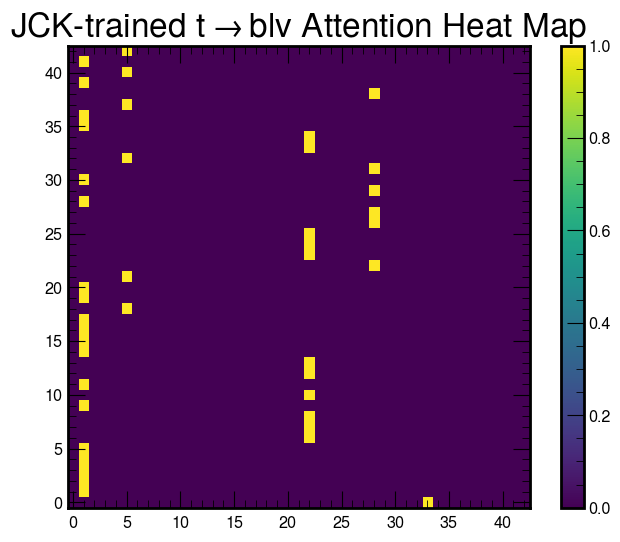

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are already defined
# Example dummy data for context:
# attention = np.random.rand(12, 128, 64, 64)  # A random tensor for illustration purposes
# num = 50  # You can replace this with your actual value

# Plotting the attention matrix with the origin in the lower left
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Visualizing a specific part of the attention matrix
plt.imshow(jck_attention[7][1][1, 0:jck_jet_num, 0:jck_jet_num], origin='lower', cmap='viridis')

# Adding colorbar
plt.colorbar()

# Set the x and y ticks to integer values
plt.xticks(np.arange(0, jck_jet_num, step=5))  # Set x-axis ticks as integers with step size of 5
plt.yticks(np.arange(0, jck_jet_num, step=5))  # Same for y-axis
plt.title(r'JCK-trained $t\rightarrow blv$ Attention Heat Map', fontsize=24)

# Using LaTeX for the title in particle decay process format

# Save the plot to a file
plt.savefig('JetClasskin_results/heatmaps/jck_heatmap_TTBarLep_head.pdf', bbox_inches="tight")

# Show the plot
plt.show()


In [ ]:
interaction = model[0].get_interactionMatrix()


In [ ]:
interaction.shape

In [ ]:
interaction= np.reshape(interaction, (attention[0].shape))


In [ ]:
intstack = []
for x in range(8):
  intstack.append(interaction)

In [ ]:
intstack = np.stack(intstack)

In [ ]:
intstack = intstack.transpose(1,0,2,3,4)

In [ ]:
atstack = np.stack(attention).transpose(1,0,2,3,4)

In [ ]:
import numpy as np

epsilon = 1e-10
log_softmaxed_attn = np.log(atstack + 1e-10)


pre_attn_matrix= log_softmaxed_attn - intstack



In [ ]:
attentionOnly = pre_attn_matrix

In [ ]:
attentionOnly.shape

In [114]:
jet = 9
head = 0
layer = 0

In [115]:
number = jet
num = 0
for b in np.squeeze(jck_pf_mask[number]):
    if b == 0:
        break
    num = num + 1

print(num)

22


In [22]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import torch
import fastjet


def get_subjets(px, py, pz, e, N_SUBJETS=3, JET_ALGO="kt", jet_radius=0.8):
    """
    Declusters a jet into exactly N_SUBJETS using the JET_ALGO and jet_radius provided.

    Args:
        px [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the px of each particle inside the jet
        py [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the py of each particle inside the jet
        pz [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the pz of each particle inside the jet
        e [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the e of each particle inside the jet
        N_SUBJETS [int]: Number of subjets to decluster the jet into
            (default is 3)
        JET_ALGO [str]: The jet declustering algorithm to use. Choices are ["CA", "kt", "antikt"]
            (default is "CA")
        jet_radius [float]: The jet radius to use when declustering
            (default is 0.8)

    Returns:
        subjet_idx [np.array]: NumPy array of shape ``[num_particles]`` with elements
                                representing which subjet the particle belongs to
        subjet_vectors [list]: includes bjet information (e.g. px, py, pz)

    """
    import awkward as ak
    import fastjet
    import vector

    if JET_ALGO == "kt":
        JET_ALGO = fastjet.kt_algorithm
    elif JET_ALGO == "antikt":
        JET_ALGO = fastjet.antikt_algorithm
    elif JET_ALGO == "CA":
        JET_ALGO = fastjet.cambridge_algorithm

    jetdef = fastjet.JetDefinition(JET_ALGO, jet_radius)

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
        },
        with_name="MomentumArray4D",
    )

    pseudojet = [
        fastjet.PseudoJet(particle.px.item(), particle.py.item(), particle.pz.item(), particle.E.item()) for particle in jet
    ]

    cluster = fastjet.ClusterSequence(pseudojet, jetdef)

    # cluster jets
    jets = cluster.inclusive_jets()
    print(len(jets))
    #assert len(jets) == 1

    # get the 3 exclusive jets
    subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
    assert len(subjets) == N_SUBJETS

    # sort by pt
    subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

    # define a subjet_idx placeholder
    subjet_idx = ak.zeros_like(px, dtype=int) - 1
    mapping = subjet_idx.to_list()

    subjet_indices = []
    for subjet_idx, subjet in enumerate(subjets):
        subjet_indices.append([])
        for subjet_const in subjet.constituents():
            for idx, jet_const in enumerate(pseudojet):
                if (
                    subjet_const.px() == jet_const.px()
                    and subjet_const.py() == jet_const.py()
                    and subjet_const.pz() == jet_const.pz()
                    and subjet_const.E() == jet_const.E()
                ):
                    subjet_indices[-1].append(idx)


    for subjet_idx, subjet in enumerate(subjets):
        local_mapping = np.array(mapping)
        local_mapping[subjet_indices[subjet_idx]] = subjet_idx
        mapping = local_mapping

    # add the jet index
    jet["subjet_idx"] = ak.Array(mapping)

    subjet_vectors = [
        vector.obj(
            px=ak.sum(jet.px[jet.subjet_idx == j], axis=-1),
            py=ak.sum(jet.py[jet.subjet_idx == j], axis=-1),
            pz=ak.sum(jet.pz[jet.subjet_idx == j], axis=-1),
            E=ak.sum(jet.E[jet.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    return jet["subjet_idx"].to_numpy(), subjet_vectors


def scaling_up(outpath, epoch, N_values=30, N_SUBJETS=3, JET_ALGO="CA", jet_radius=0.8):
    """
    Computes the distribution of edges connecting different subjets for different values of N.

    Args:
        outpath [str]: Path to load the Rscores pkl files
        epoch [int]: The epoch at which to load the model
            (if -1: best trained model, if 0: untrained model, otherwise loads the corresponding epoch)
        N_values [int]: The different values of N to scan, which will be taken as range(N_values)
            (default is 15)
        N_SUBJETS [int]: Number of subjets to decluster the jet into
            (default is 3)
        JET_ALGO [str]: The jet declustering algorithm to use. Choices are ["CA", "kt", "antikt"]
            (default is "CA")
        jet_radius [float]: The jet radius to use when declustering
            (default is 0.8)

    """

    # same: list of counters, for each N, of edges connecting the same subjet
    top_same, qcd_same = np.array([0] * N_values), np.array([0] * N_values)
    # diff: list of counters, for each N, of edges connecting different subjets
    top_diff, qcd_diff = np.array([0] * N_values), np.array([0] * N_values)

    if epoch == -1:
        PATH = f"{outpath}/Rscores_best"
        save_as = "best"
        legend_title = "Trained model"
    elif epoch == 0:
        PATH = f"{outpath}/Rscores_untrained"
        save_as = "untrained"
        legend_title = "Untrained model"
    else:
        PATH = f"{outpath}/Rscores_epoch_{epoch}"
        save_as = f"epoch_{epoch}"
        legend_title = f"Model at epoch {epoch}"

    # load the jet information
    with open(f"{PATH}/batch_y.pkl", "rb") as handle:
        batch_y_list = pkl.load(handle)
    with open(f"{PATH}/batch_p4.pkl", "rb") as handle:
        batch_p4_list = pkl.load(handle)

    # load the edgeRscores and edge_index of each EdgeConv block
    with open(f"{PATH}/R_edges.pkl", "rb") as handle:
        R_edges_list = pkl.load(handle)
    with open(f"{PATH}/edge_index.pkl", "rb") as handle:
        edge_index_list = pkl.load(handle)

    Num_jets = len(batch_p4_list)
    print(f"Total # of jets is {Num_jets}")
    for i in range(Num_jets):
        # define the jet information
        jet_label = batch_y_list[i]

        px = batch_p4_list[i][:, 0]
        py = batch_p4_list[i][:, 1]
        pz = batch_p4_list[i][:, 2]
        e = batch_p4_list[i][:, 3]

        # define the edgeRscores and the edge_index of the last EdgeConv block
        edge_Rscores = R_edges_list[i]["edge_conv_2"]
        edge_index = edge_index_list[i]["edge_conv_2"]

        # get subjets
        try:
            print(f"- Declustering jet # {i} using {JET_ALGO} algorithm")
            subjet_idx, _ = get_subjets(px, py, pz, e, N_SUBJETS, JET_ALGO, jet_radius)
        except AssertionError:
            print(f"skipping jet # {i}")
            continue

        for N in range(N_values):
            # N=0 doesn't make sense here
            for edge in torch.topk(edge_Rscores, N + 1).indices:
                if jet_label == 1:
                    if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
                        top_diff[N] += 1
                    else:
                        top_same[N] += 1
                else:
                    if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
                        qcd_diff[N] += 1
                    else:
                        qcd_same[N] += 1

    top_fraction = top_diff / (top_same + top_diff)
    qcd_fraction = qcd_diff / (qcd_same + qcd_diff)

    outpath = f"{outpath}/scaling_up"
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    with open(f"{outpath}/top_fraction_{save_as}.pkl", "wb") as f:
        pkl.dump(top_fraction, f)
    with open(f"{outpath}/qcd_fraction_{save_as}.pkl", "wb") as f:
        pkl.dump(qcd_fraction, f)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(range(len(top_fraction)), top_fraction, label="Top")
    ax.plot(range(len(qcd_fraction)), qcd_fraction, label="QCD")
    ax.legend(title=legend_title)
    ax.set_xlabel(r"$N_{edges}$", fontsize=20)
    ax.set_ylabel(r"$N_{edges \ between \ subjets}$ / $N_{edges}$", fontsize=20)
    fig.tight_layout()
    plt.savefig(f"{outpath}/scaling_up_{save_as}.pdf")
    print(f"saved the plot as {outpath}/scaling_up_{save_as}.pdf")

In [ ]:
jck_subjets = get_subjets(jck_pf_vectors[jet][0][0:jck_jet_num],jck_pf_vectors[jet][1][0:jck_jet_num], jck_pf_vectors[jet][2][0:jck_jet_num], jck_pf_vectors[jet][3][0:jck_jet_num], N_SUBJETS=2,  JET_ALGO="kt")

1#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------



In [33]:
labels[6]

NameError: name 'labels' is not defined

In [ ]:

jet = 4
number = jet
num = 0
for b in np.squeeze(pf_mask[number]):
    if b == 0:
        break
    num = num + 1

In [ ]:
deta = pf_features[jet][15][0:num]
dphi = pf_features[jet][16][0:num]
pt = pf_features[jet][0][0:num]

In [ ]:
deta = pf_features[jet][15][0:num]
dphi = pf_features[jet][16][0:num]
pt = pf_features[jet][0][0:num]
detaCH = []
detaNH = []
detaMuon = []
detaElectron = []
detaPhoton = []
dphiCH = []
dphiNH = []
dphiMuon = []
dphiElectron = []
dphiPhoton = []
ptCH = []
ptNH = []
ptPhoton = []
ptMuon = []
ptElectron = []
for particle in range(len(deta)):
    if pf_features[jet][6][particle] == 1:
        detaCH.append(pf_features[jet][15][particle])
        dphiCH.append(pf_features[jet][16][particle])
        ptCH.append(pf_features[jet][0][particle])
    elif pf_features[jet][7][particle] == 1:
        detaNH.append(pf_features[jet][15][particle])
        dphiNH.append(pf_features[jet][16][particle])
        ptNH.append(pf_features[jet][0][particle])

    elif pf_features[jet][8][particle] == 1:
        detaPhoton.append(pf_features[jet][15][particle])
        dphiPhoton.append(pf_features[jet][16][particle])
        ptPhoton.append(pf_features[jet][0][particle])
    elif pf_features[jet][9][particle] == 1:
        detaElectron.append(pf_features[jet][15][particle])
        dphiElectron.append(pf_features[jet][16][particle])
        ptElectron.append(pf_features[jet][0][particle])

    elif pf_features[jet][10][particle] == 1:
        detaMuon.append(pf_features[jet][15][particle])
        dphiMuon.append(pf_features[jet][16][particle])

        ptMuon.append(pf_features[jet][0][particle])


In [ ]:
attention[0].shape

In [ ]:
attention[x][jet][:,0:num,0:num].shape

In [ ]:
attention[x][jet][:][0:num,0:num].shape

In [ ]:
attentionOnly.shape

In [ ]:
attentionOnly = np.transpose(attentionOnly,[1,0,2,3,4])

In [ ]:
attentionOnly.shape

In [ ]:
import scipy

In [ ]:
correlation = []
for indexed in range(8):
  correlation.append(scipy.stats.pearsonr(attention[0][jet][:,0:num,0:num][indexed].flatten(), attentionOnly[0][jet][:,0:num,0:num][indexed].flatten()))


In [ ]:
correlation

In [23]:
CMS = {
    # "font.sans-serif": ["TeX Gyre Heros", "Helvetica", "Arial"],
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (8.0, 8.0),
    "font.size": 14,
    #"text.usetex": True,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    # Make legends smaller
    "legend.fontsize": "x-small",  # Adjusted to a smaller size
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
}
plt.style.use(CMS)


In [ ]:
random_matrix = np.random.rand(2, 2, 8, 128,128)


In [ ]:
from scipy.special import softmax

srandom_matrix = softmax(random_matrix, axis = 4)

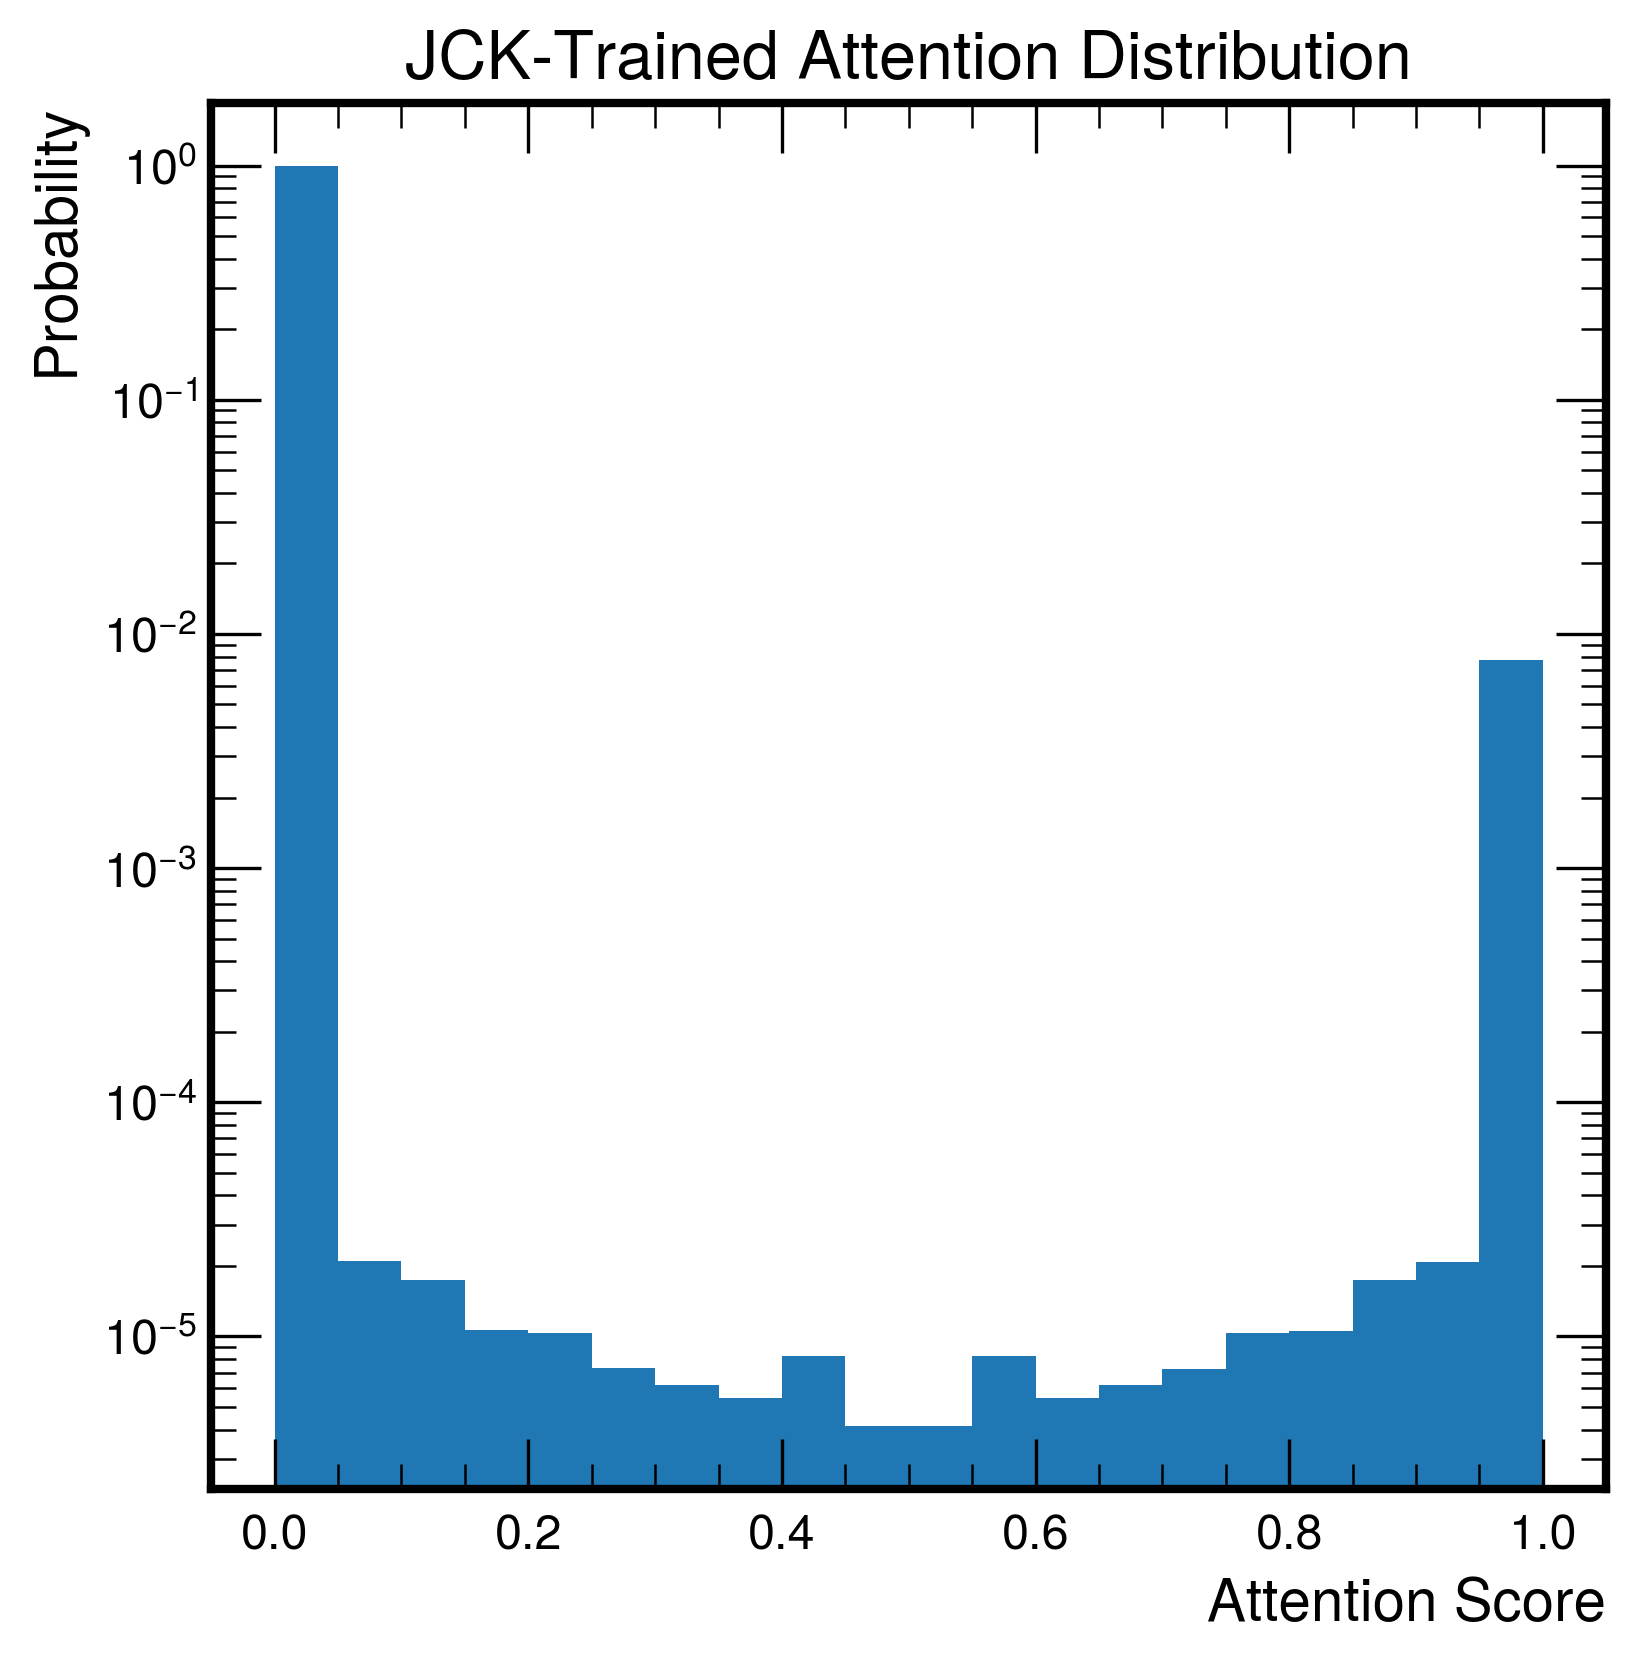

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming attention is already a list or array
# Flattening the attention array
flattened_attention = np.stack(jck_attention).flatten()

# Define number of bins for the probability distribution
num_bins = 20

# Define the bin edges between 0 and 1, using 20 evenly spaced bins
bin_edges = np.linspace(0, 1, num_bins + 1)

# Function to process data in chunks and compute histogram
def process_in_chunks(attention_iterator, chunk_size=100000, bin_edges=bin_edges):
    hist_counts = np.zeros(len(bin_edges) - 1)  # Initialize histogram counts for bins

    # Process each chunk of attention data
    for chunk in attention_iterator:
        # Flatten the chunk to ensure it's 1D and processable by np.histogram
        chunk = np.array(chunk).flatten()

        # Calculate histogram for this chunk
        hist, _ = np.histogram(chunk, bins=bin_edges)

        # Accumulate the counts
        hist_counts += hist

    total_data_points = hist_counts.sum()  # Total number of points processed
    probabilities = hist_counts / total_data_points  # Normalize to get probabilities
    return probabilities

# Simulate loading a large dataset in chunks (e.g., from a file or other source)
def attention_generator(attention, chunk_size):
    """Simulate chunked data loader for large dataset."""
    for i in range(0, len(attention), chunk_size):
        yield attention[i:i + chunk_size]

# Process the data in chunks (using a generator)
probabilities = process_in_chunks(attention_generator(flattened_attention, chunk_size=100000))

# Manually set the bin centers to have equal bar spacing
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate the centers of each bin
equal_width = bin_edges[1] - bin_edges[0]  # Set equal width for all bars based on bin spacing

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

# Plot bar graph with equal-width bars
ax.bar(bin_centers, probabilities, width=equal_width, log=False)  # No log scale for clearer visualization

# Set custom x-tick locations and labels (optional)
#ax.set_xticks(bin_centers, 0.1)
#ax.set_xticklabels([f'{edge:.2f}' for edge in bin_centers], fontsize=10, fontweight='bold')

# Set x and y axis labels
ax.set_xlabel('Attention Score', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
plt.yscale('log')

# Add a title
ax.set_title('JCK-Trained Attention Distribution', fontsize=16)
plt.savefig('JetClasskin_results/attn_dists/jck_attentionDist_TTBarLep.pdf', bbox_inches="tight")

# Show the plot
plt.show()


In [24]:
#load data to tag Particle IDs in attention line plot below

jck_data_PIDs = load_data(dataset_type='jck_pid', filepath='/mnt/c/Interpretability_Data/JetClass/test_20M/HToWW2Q1L_100.root', batch_size=300)

jck_pid_trained_modelpath = '/home/tim_legge/particle_transformer_legge/models/ParT_kinpid.pt'

model = get_model(model_type='jck_pid')
jck_pid_state_dict = torch.load(jck_pid_trained_modelpath, map_location=torch.device('cpu'))
model[0].load_state_dict(jck_pid_state_dict)
jck_pids_pf_features = jck_data_PIDs['pf_features'][200:300]
jck_pids_pf_vectors = jck_data_PIDs['pf_vectors'][200:300]
jck_pids_pf_mask = jck_data_PIDs['pf_mask'][200:300]
jck_pids_pf_points = jck_data_PIDs['pf_points'][200:300]
jck_pids_labels = jck_data_PIDs['labels'][200:300]
model[0].eval()
with torch.no_grad():
    jck_y_pred= model[0](torch.from_numpy(jck_pids_pf_points),torch.from_numpy(jck_pids_pf_features),torch.from_numpy(jck_pids_pf_vectors),torch.from_numpy(jck_pids_pf_mask))
jck_pid_attention = model[0].get_attention_matrix()
jck_pid_interaction = model[0].get_interactionMatrix()

Loading actual JetClass data from /mnt/c/Interpretability_Data/JetClass/test_20M/HToWW2Q1L_100.root
This part is working - JCK
Truncating from 100000 jets to 300 jets


In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable

# Define a function to plot the particles and attention lines
def plot_attention_with_particles(attention_head, jet, deta_all, dphi_all, pt_all, subjets_all, layer_number, head_number, pf_features, output_filename):

    # Normalize pt values for alpha transparency
    print("Normalizing pt values...")
    norm_pt = mcolors.Normalize(vmin=pt_all.min(), vmax=pt_all.max())

    # Identify the lowest Pt subjet
    unique_subjets = np.unique(subjets_all)
    print(f"Unique subjets: {unique_subjets}")
    lowest_pt_subjet = min(np.unique(subjets_all), key=lambda s: np.sum(pt_all[subjets_all == s]))
    print(f"Lowest Pt subjet: {lowest_pt_subjet}")

    # Use a bright colormap
    colormap = plt.get_cmap('spring')

    # Normalize attention for line transparency/width
    print("Normalizing attention values...")
    norm_attention = mcolors.Normalize(vmin=attention_head.min(), vmax=attention_head.max())


    # Set figure size and DPI for faster rendering
    print("Setting up figure...")
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)  # Increase DPI for better rendering

    # Preprocess data to plot particles in batches based on their properties
    print("Categorizing particles...")
    particle_groups = {
        'charged_hadron': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': '^'},
        'neutral_hadron': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'v'},
        'photon': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'o'},
        'electron': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'P'},
        'muon': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'X'},
        'default': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'o'}
    }

    for i in range(len(deta_all)):
        # Alpha transparency based on pt with a minimum of 0.5 and scaling with normalized pt
        alpha = max(0.5, norm_pt(pt_all[i]))
#if subjets_all[i] == lowest_pt_subjet:
        #else:
        other_subjet_idx = np.where(unique_subjets == subjets_all[i])[0][0]
        color = colormap(other_subjet_idx / len(unique_subjets) * 0.7)  # Bright colors

        # Determine the marker based on the particle type in pf_features
        if pf_features[jet][6][i] == 1:  # Charged Hadron
            group = 'charged_hadron'
        elif pf_features[jet][7][i] == 1:  # Neutral Hadron
            group = 'neutral_hadron'
        elif pf_features[jet][8][i] == 1:  # Photon
            group = 'photon'
        elif pf_features[jet][9][i] == 1:  # Electron
            group = 'electron'
        elif pf_features[jet][10][i] == 1:  # Muon
            group = 'muon'
        else:
            group = 'default'

        # Store the particle data in the appropriate group for batch plotting
        particle_groups[group]['deta'].append(deta_all[i])
        particle_groups[group]['dphi'].append(dphi_all[i])
        particle_groups[group]['color'].append(color)
        particle_groups[group]['alpha'].append(alpha)

    print("Plotting particles...")
    # Batch plot particles for each group
    for group, data in particle_groups.items():
        if data['deta']:  # Only plot if there are particles in this group
            # Apply alpha transparency as an array for each particle
            ax.scatter(data['deta'], data['dphi'], color=data['color'], alpha=data['alpha'], s=250, zorder=3, marker=data['marker'],
                       edgecolors='black', linewidths=1.5, antialiased=False)  # Disable anti-aliasing for speed

    # Plot attention lines between particles with values above 0.9
    print("Plotting attention lines...")
    for i in range(attention_head.shape[0]):
        for j in range(attention_head.shape[1]):
            if i != j:  # No self-loops
                # Attention value between particles i and j
                attn_value = attention_head[i, j]
                linestyle = ''
                lineValue=1
                if attn_value > 0:  # Only plot lines for attention values >= 0.9
                    alpha = norm_attention(attn_value)  # Transparency based on attention
                    lineValue = 1
                    # Solid lines within the same subjet, dashed between different subjets
                    linestyle = ''
                    if subjets_all[i] == subjets_all[j]:
                        linestyle = 'solid'
                        lineValue = 1
                    else:
                        linestyle = 'dotted'
                        linestyle = (0, (2, 2))
                        lineValue = 1.3

                    # Plot lines
                    ax.plot([deta_all[i], deta_all[j]], [dphi_all[i], dphi_all[j]], color='black',
                            alpha=alpha, linewidth=lineValue * alpha, linestyle=linestyle, antialiased=False)  # Disable anti-aliasing for speed

    print("Adding legends...")

    # Add the subjet legend without Pt values
    legend1 = ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'Subjet {int(subjet)}', markerfacecolor=colormap(subjet / len(unique_subjets) * 0.7), markersize=10)
        for subjet in unique_subjets
    ], loc='upper right', title="Subjets")

    # Add the particle shape legend
    #legend2 = ax.legend(handles=[
    #    plt.Line2D([0], [0], marker=group['marker'], color='w', label=label, markerfacecolor='black', markersize=10)
    #    for label, group in zip(['Charged Hadron', 'Neutral Hadron', 'Photon', 'Electron', 'Muon'], particle_groups.values())
    #], loc='lower right', title="Particle Shapes")

    # Add all legends to the plot
    ax.add_artist(legend1)
    #ax.add_artist(legend2)

    # Set axis labels without bold styling
    ax.set_xlabel(r'$\Delta \eta$')
    ax.set_ylabel(r'$\Delta \phi$')

    # Add title with layer and head information
    #ax.set_title(f'Layer {layer_number + 1} - Head {head_number + 1}')
    ax.set_title('Untrained Model')

    #ax.set_xlim(-0.4, 0.7)
    #ax.set_xticks(np.arange(-0.4, 0.7, 0.2))

    # Add a colorbar for the attention weights at the bottom
    #cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.03])  # Add a colorbar axis below the plot
    cmap = plt.cm.gray_r  # Use a gray colormap to represent attention weights
    vmin=attention_head.min()
    vmax=attention_head.max()
    norm = plt.Normalize(vmin=attention_head.min(), vmax=attention_head.max())  # Normalize based on attention values
    #cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cb = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap))
    cb.set_label('Attention Weight')

    # Save the figure instead of showing it
    print(f"Saving figure to {output_filename}...")
    #plt.savefig(output_filename, bbox_inches='tight')
    print("Figure saved.")

def jck_plot_attention_with_particles(attention_head, jet, deta_all, dphi_all, pt_all, subjets_all, layer_number, head_number, pf_features, output_filename):

    # Normalize pt values for alpha transparency
    print("Normalizing pt values...")
    norm_pt = mcolors.Normalize(vmin=pt_all.min(), vmax=pt_all.max())

    # Identify the lowest Pt subjet
    unique_subjets = np.unique(subjets_all)
    print(f"Unique subjets: {unique_subjets}")
    lowest_pt_subjet = min(np.unique(subjets_all), key=lambda s: np.sum(pt_all[subjets_all == s]))
    print(f"Lowest Pt subjet: {lowest_pt_subjet}")

    # Use a bright colormap
    colormap = plt.get_cmap('spring')

    # Normalize attention for line transparency/width
    print("Normalizing attention values...")
    norm_attention = mcolors.Normalize(vmin=attention_head.min(), vmax=attention_head.max())


    # Set figure size and DPI for faster rendering
    print("Setting up figure...")
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)  # Increase DPI for better rendering

    # Preprocess data to plot particles in batches based on their properties
    print("Categorizing particles...")
    particle_groups = {
        'default': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'o'}
    }

    for i in range(len(deta_all)):
        # Alpha transparency based on pt with a minimum of 0.5 and scaling with normalized pt
        alpha = max(0.5, norm_pt(pt_all[i]))
#if subjets_all[i] == lowest_pt_subjet:
        #else:
        other_subjet_idx = np.where(unique_subjets == subjets_all[i])[0][0]
        color = colormap(other_subjet_idx / len(unique_subjets) * 0.7)  # Bright colors

        group = 'default' # TopLandscape does not include Particle ID features, so we use a default group

        # Store the particle data in the appropriate group for batch plotting
        particle_groups[group]['deta'].append(deta_all[i])
        particle_groups[group]['dphi'].append(dphi_all[i])
        particle_groups[group]['color'].append(color)
        particle_groups[group]['alpha'].append(alpha)

    print("Plotting particles...")
    # Batch plot particles for each group
    for group, data in particle_groups.items():
        if data['deta']:  # Only plot if there are particles in this group
            # Apply alpha transparency as an array for each particle
            ax.scatter(data['deta'], data['dphi'], color=data['color'], alpha=data['alpha'], s=250, zorder=3, marker=data['marker'],
                       edgecolors='black', linewidths=1.5, antialiased=False)  # Disable anti-aliasing for speed

    # Plot attention lines between particles with values above 0.9
    print("Plotting attention lines...")
    for i in range(attention_head.shape[0]):
        for j in range(attention_head.shape[1]):
            if i != j:  # No self-loops
                # Attention value between particles i and j
                attn_value = attention_head[i, j]
                linestyle = ''
                lineValue=1
                if attn_value > 0:  # Only plot lines for attention values >= 0.9
                    alpha = norm_attention(attn_value)  # Transparency based on attention
                    lineValue = 1
                    # Solid lines within the same subjet, dashed between different subjets
                    linestyle = ''
                    if subjets_all[i] == subjets_all[j]:
                        linestyle = 'solid'
                        lineValue = 1
                    else:
                        linestyle = 'dotted'
                        linestyle = (0, (2, 2))
                        lineValue = 1.3

                    # Plot lines
                    ax.plot([deta_all[i], deta_all[j]], [dphi_all[i], dphi_all[j]], color='black',
                            alpha=alpha, linewidth=lineValue * alpha, linestyle=linestyle, antialiased=False)  # Disable anti-aliasing for speed

    print("Adding legends...")

    # Add the subjet legend without Pt values
    legend1 = ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'Subjet {int(subjet)}', markerfacecolor=colormap(subjet / len(unique_subjets) * 0.7), markersize=10)
        for subjet in unique_subjets
    ], loc='upper right', title="Subjets")

    # Add all legends to the plot
    ax.add_artist(legend1)

    # Set axis labels without bold styling
    ax.set_xlabel(r'$\Delta \eta$')
    ax.set_ylabel(r'$\Delta \phi$')

    # Add title with layer and head information
    ax.set_title(f'Layer {layer_number + 1} - Head {head_number + 1}')
    #ax.set_title('Untrained Model')

    #ax.set_xlim(-0.4, 0.7)
    #ax.set_xticks(np.arange(-0.4, 0.7, 0.2))

    # Add a colorbar for the attention weights at the bottom
    #cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.03])  # Add a colorbar axis below the plot
    cmap = plt.cm.gray_r  # Use a gray colormap to represent attention weights
    vmin=attention_head.min()
    vmax=attention_head.max()
    norm = plt.Normalize(vmin=attention_head.min(), vmax=attention_head.max())  # Normalize based on attention values
    #cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cb = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap))
    cb.set_label('Attention Weight')

    # Save the figure instead of showing it
    print(f"Saving figure to {output_filename}...")
    plt.savefig(output_filename, bbox_inches='tight')
    print("Figure saved.")

def jck_plot_attention_with_particles_and_ids(attention_head, jet, deta_all, dphi_all, pt_all, subjets_all, layer_number, head_number, pf_features, output_filename):

    # Normalize pt values for alpha transparency
    print("Normalizing pt values...")
    norm_pt = mcolors.Normalize(vmin=pt_all.min(), vmax=pt_all.max())

    # Identify the lowest Pt subjet
    unique_subjets = np.unique(subjets_all)
    print(f"Unique subjets: {unique_subjets}")
    lowest_pt_subjet = min(np.unique(subjets_all), key=lambda s: np.sum(pt_all[subjets_all == s]))
    print(f"Lowest Pt subjet: {lowest_pt_subjet}")

    # Use a bright colormap
    colormap = plt.get_cmap('spring')

    # Normalize attention for line transparency/width
    print("Normalizing attention values...")
    norm_attention = mcolors.Normalize(vmin=attention_head.min(), vmax=attention_head.max())


    # Set figure size and DPI for faster rendering
    print("Setting up figure...")
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)  # Increase DPI for better rendering

    # Preprocess data to plot particles in batches based on their properties
    print("Categorizing particles...")
    particle_groups = {
        'charged_hadron': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': '^'},
        'neutral_hadron': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'v'},
        'photon': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'o'},
        'electron': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'P'},
        'muon': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'X'},
        'default': {'deta': [], 'dphi': [], 'pt': [], 'color': [], 'alpha': [], 'marker': 'o'}
    }

    for i in range(len(deta_all)):
        # Alpha transparency based on pt with a minimum of 0.5 and scaling with normalized pt
        alpha = max(0.5, norm_pt(pt_all[i]))
#if subjets_all[i] == lowest_pt_subjet:
        #else:
        other_subjet_idx = np.where(unique_subjets == subjets_all[i])[0][0]
        color = colormap(other_subjet_idx / len(unique_subjets) * 0.7)  # Bright colors

        #determine group by the pid features in jetclass_kinpid
        if jck_pids_pf_features[jet][6][i] == 1:  # Charged Hadron
            group = 'charged_hadron'
        elif jck_pids_pf_features[jet][7][i] == 1:  # Neutral Hadron
            group = 'neutral_hadron'
        elif jck_pids_pf_features[jet][8][i] == 1:  # Photon
            group = 'photon'
        elif jck_pids_pf_features[jet][9][i] == 1:  # Electron
            group = 'electron'
        elif jck_pids_pf_features[jet][10][i] == 1:  # Muon
            group = 'muon'
        else:
            group = 'default'

        # Store the particle data in the appropriate group for batch plotting
        particle_groups[group]['deta'].append(deta_all[i])
        particle_groups[group]['dphi'].append(dphi_all[i])
        particle_groups[group]['color'].append(color)
        particle_groups[group]['alpha'].append(alpha)

    print("Plotting particles...")
    # Batch plot particles for each group
    for group, data in particle_groups.items():
        if data['deta']:  # Only plot if there are particles in this group
            # Apply alpha transparency as an array for each particle
            ax.scatter(data['deta'], data['dphi'], color=data['color'], alpha=data['alpha'], s=250, zorder=3, marker=data['marker'],
                       edgecolors='black', linewidths=1.5, antialiased=False)  # Disable anti-aliasing for speed

    # Plot attention lines between particles with values above 0.9
    print("Plotting attention lines...")
    for i in range(attention_head.shape[0]):
        for j in range(attention_head.shape[1]):
            if i != j:  # No self-loops
                # Attention value between particles i and j
                attn_value = attention_head[i, j]
                linestyle = ''
                lineValue=1
                if attn_value > 0:  # Only plot lines for attention values >= 0.9
                    alpha = norm_attention(attn_value)  # Transparency based on attention
                    lineValue = 1
                    # Solid lines within the same subjet, dashed between different subjets
                    linestyle = ''
                    if subjets_all[i] == subjets_all[j]:
                        linestyle = 'solid'
                        lineValue = 1
                    else:
                        linestyle = 'dotted'
                        linestyle = (0, (2, 2))
                        lineValue = 1.3

                    # Plot lines
                    ax.plot([deta_all[i], deta_all[j]], [dphi_all[i], dphi_all[j]], color='black',
                            alpha=alpha, linewidth=lineValue * alpha, linestyle=linestyle, antialiased=False)  # Disable anti-aliasing for speed

    print("Adding legends...")

    # Add the subjet legend without Pt values
    legend1 = ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'Subjet {int(subjet)}', markerfacecolor=colormap(subjet / len(unique_subjets) * 0.7), markersize=10)
        for subjet in unique_subjets
    ], loc='upper right', title="Subjets")

    # Add the particle shape legend
    legend2 = ax.legend(handles=[
        plt.Line2D([0], [0], marker=group['marker'], color='w', label=label, markerfacecolor='black', markersize=10)
        for label, group in zip(['Charged Hadron', 'Neutral Hadron', 'Photon', 'Electron', 'Muon'], particle_groups.values())
    ], loc='upper left', title="Particle Shapes")

    # Add all legends to the plot
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    # Set axis labels without bold styling
    ax.set_xlabel(r'$\Delta \eta$')
    ax.set_ylabel(r'$\Delta \phi$')

    # Add title with layer and head information
    ax.set_title(f'Layer {layer_number + 1} - Head {head_number + 1}')
    #ax.set_title('Untrained Model')

    #ax.set_xlim(-0.4, 0.7)
    #ax.set_xticks(np.arange(-0.4, 0.7, 0.2))

    # Add a colorbar for the attention weights at the bottom
    #cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.03])  # Add a colorbar axis below the plot
    cmap = plt.cm.gray_r  # Use a gray colormap to represent attention weights
    vmin=attention_head.min()
    vmax=attention_head.max()
    norm = plt.Normalize(vmin=attention_head.min(), vmax=attention_head.max())  # Normalize based on attention values
    #cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cb = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap))
    cb.set_label('Attention Weight')

    # Save the figure instead of showing it
    print(f"Saving figure to {output_filename}...")
    plt.savefig(output_filename, bbox_inches='tight')
    print("Figure saved.")

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
1
Normalizing pt values...
Unique subjets: [0 1]
Lowest Pt subjet: 1
No

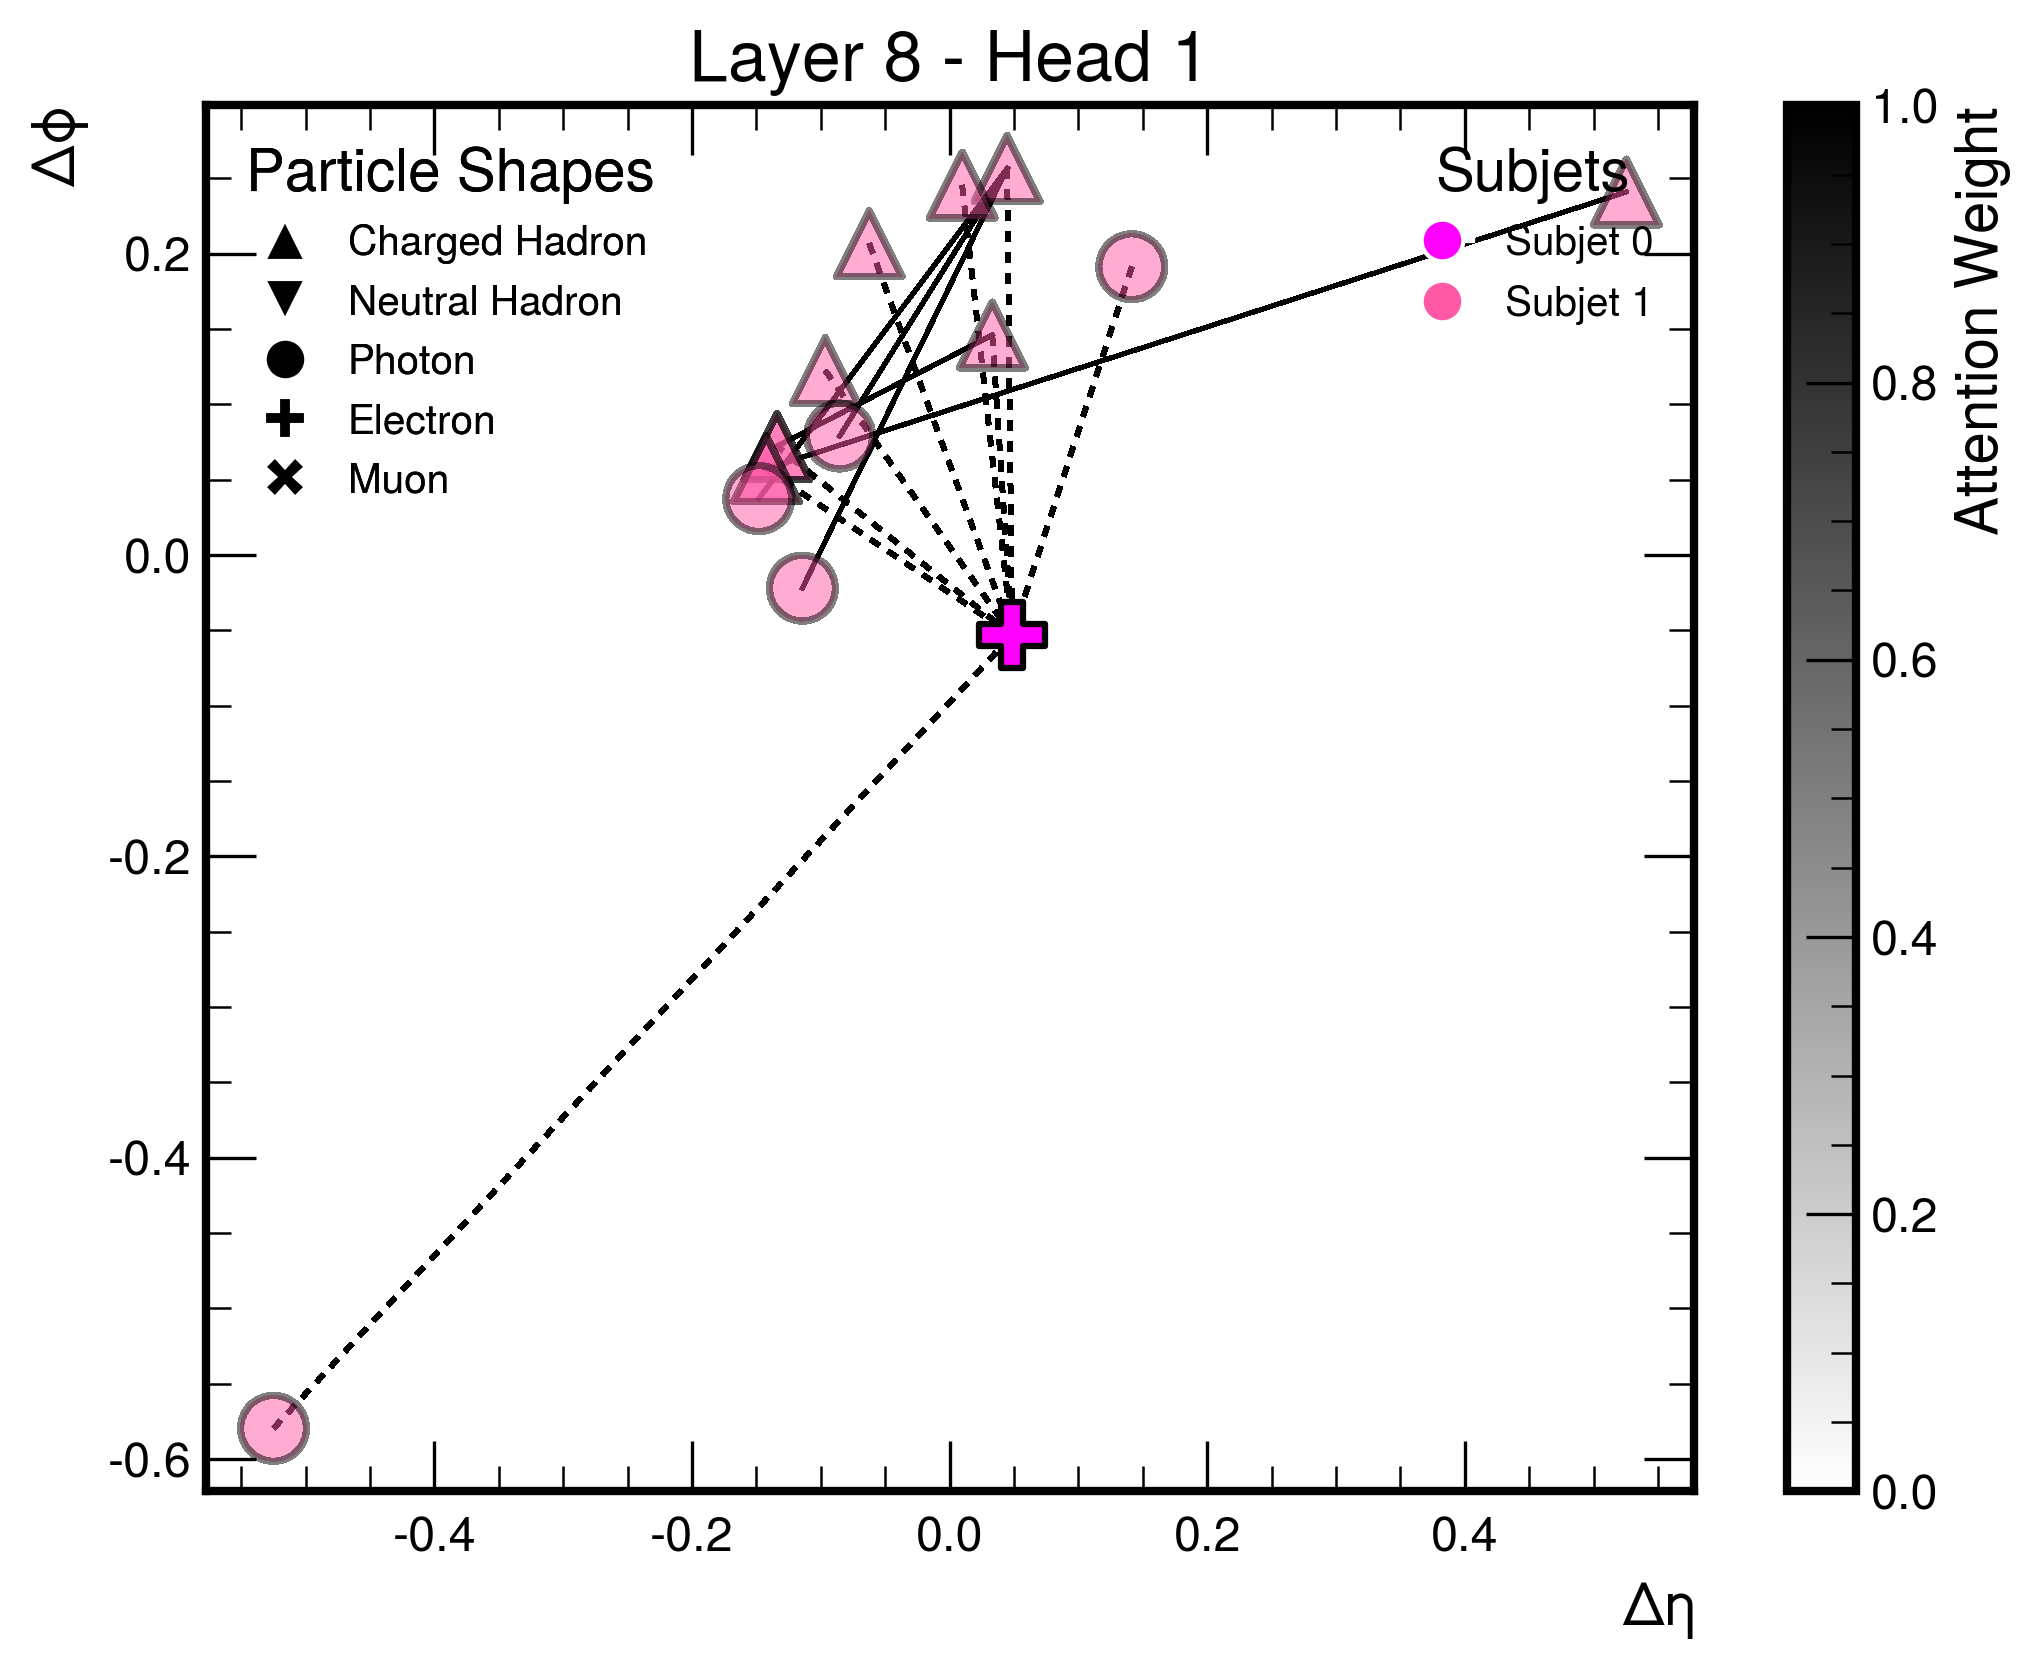

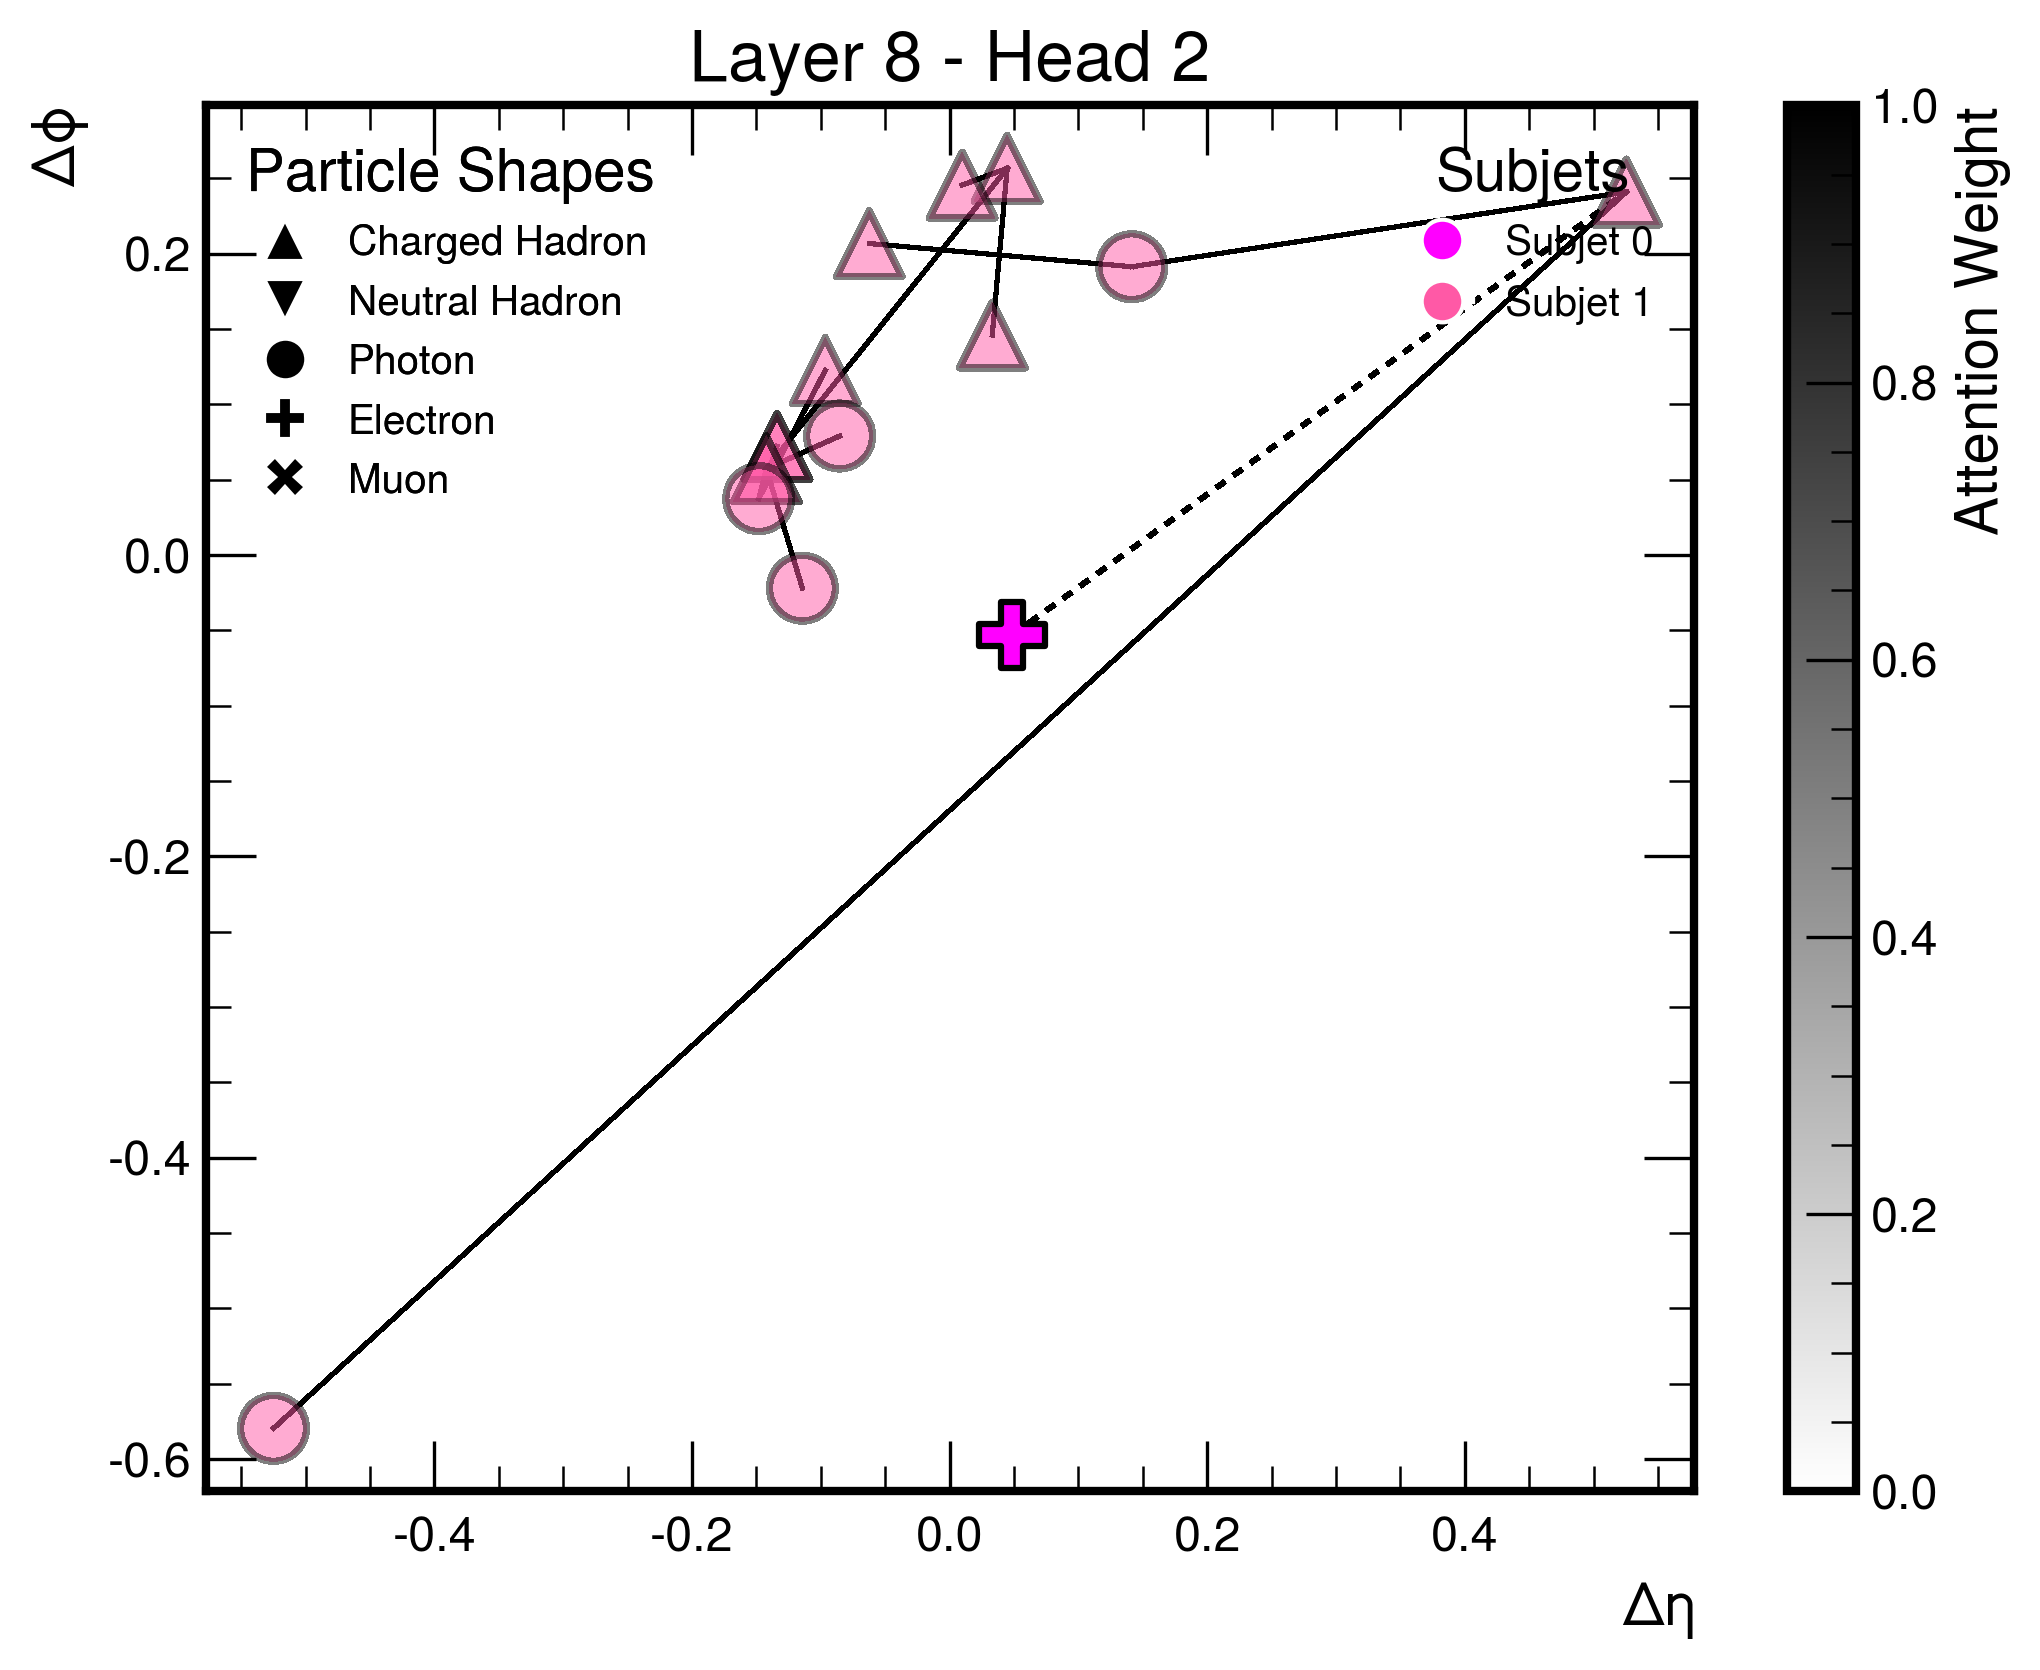

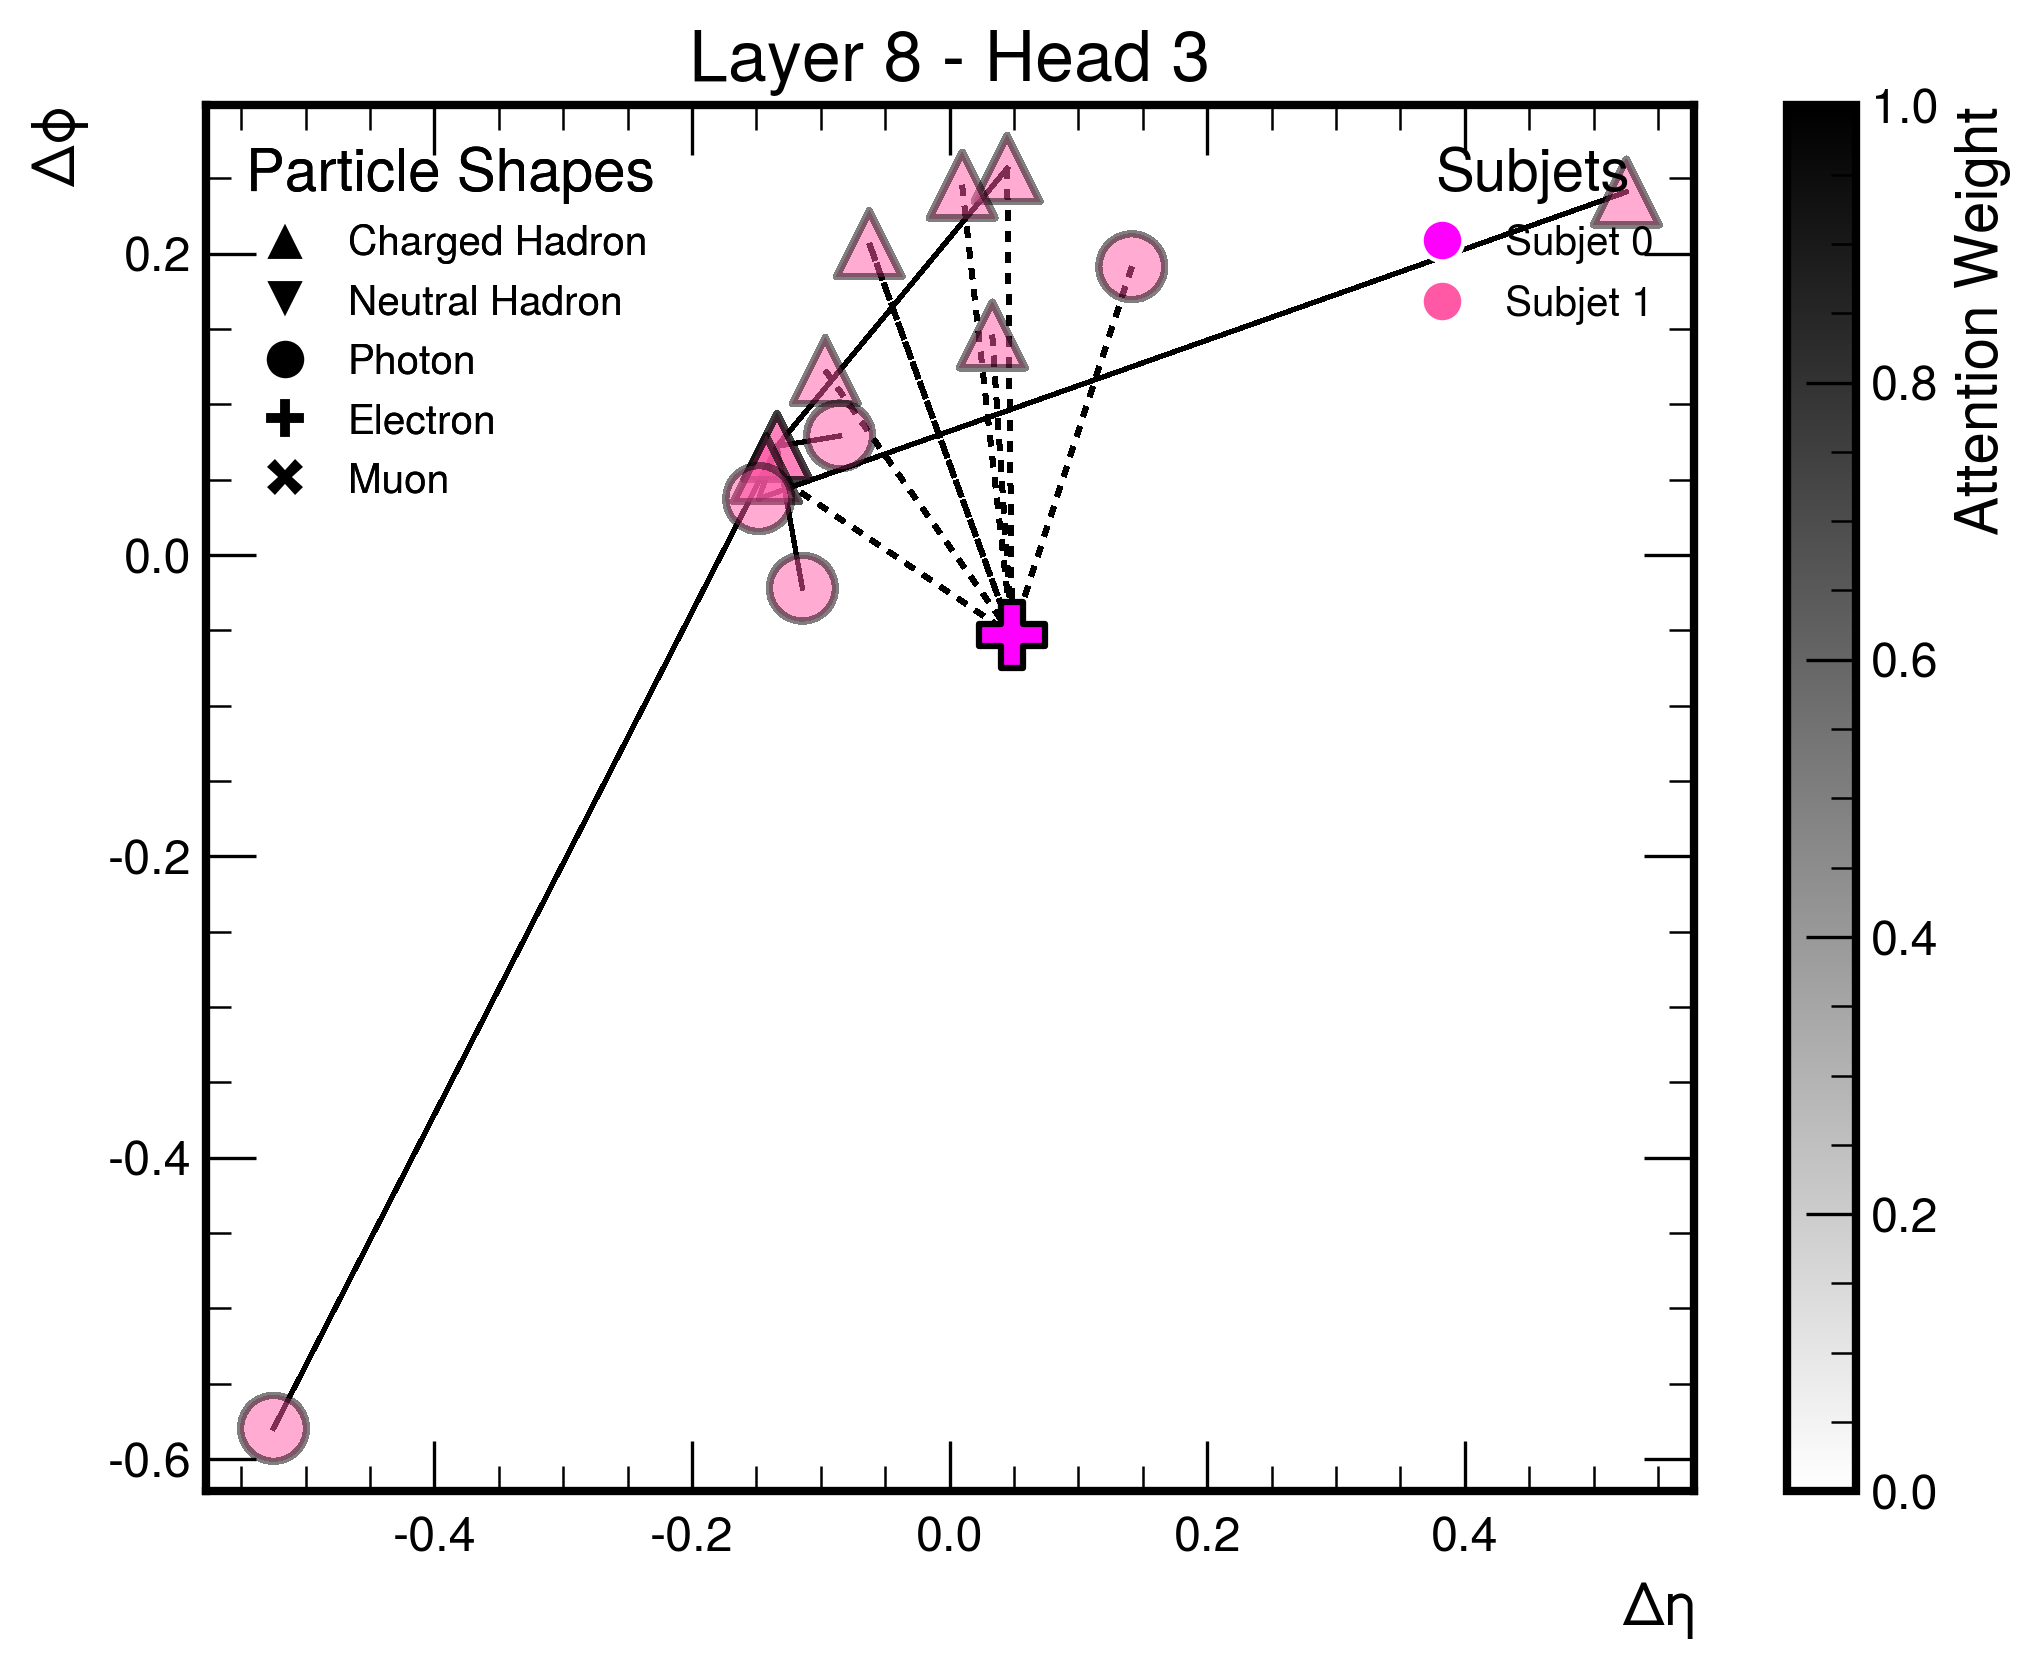

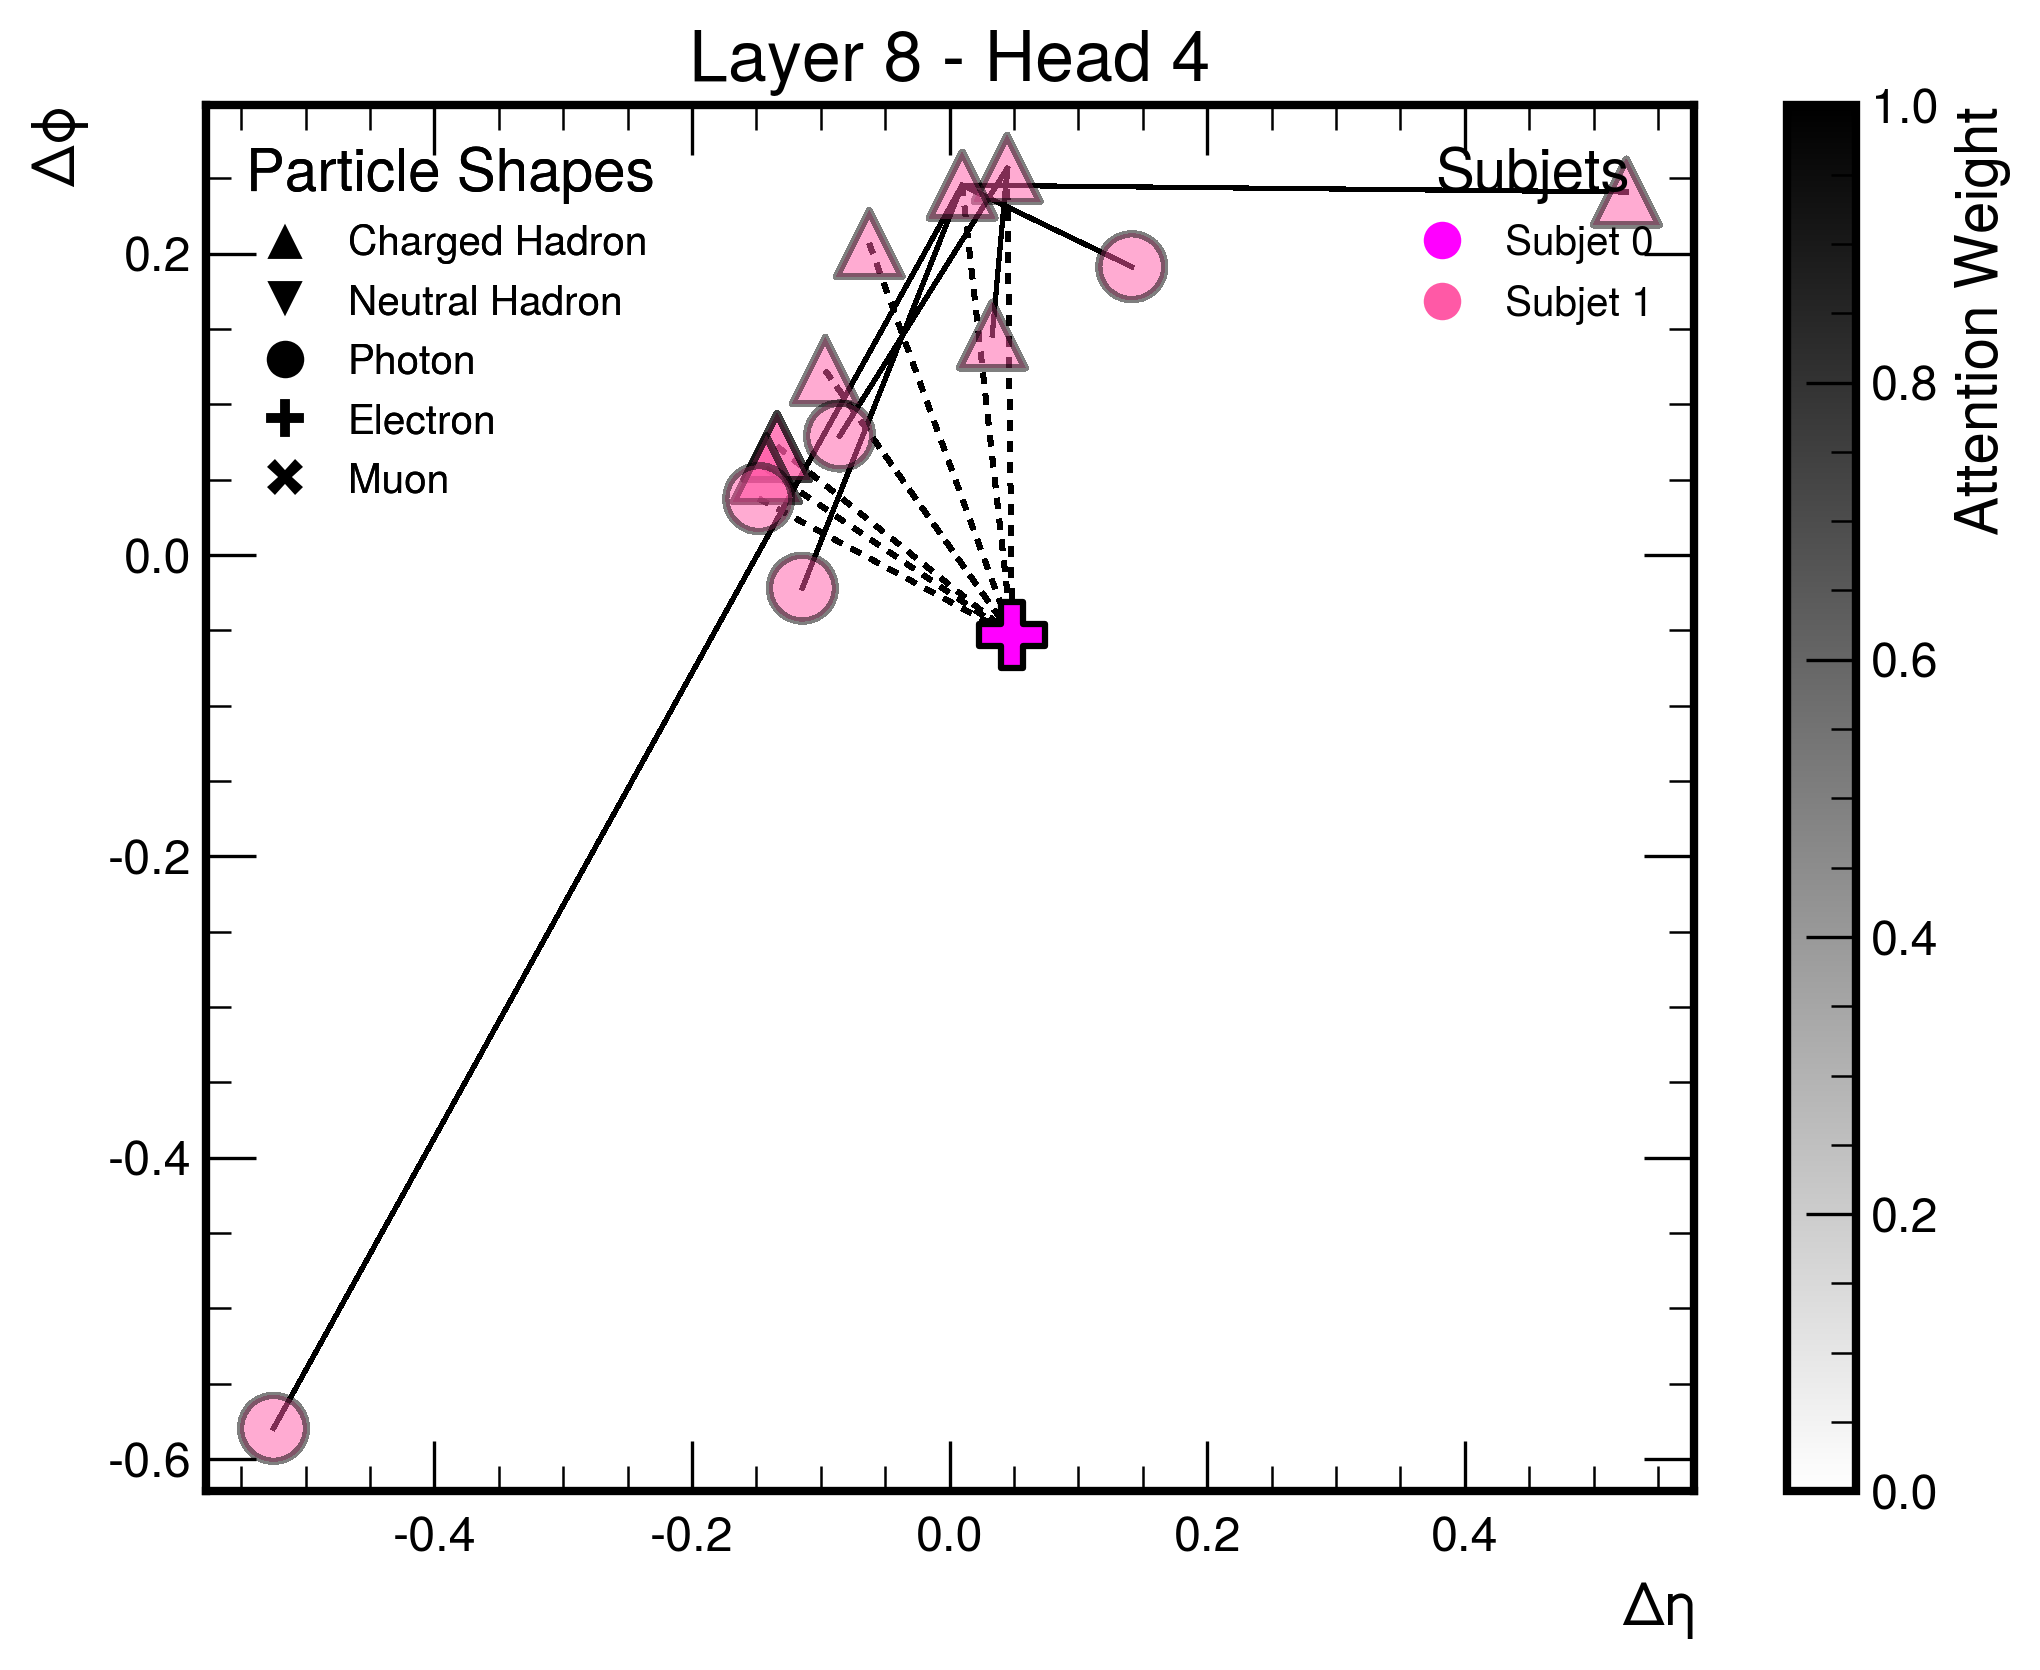

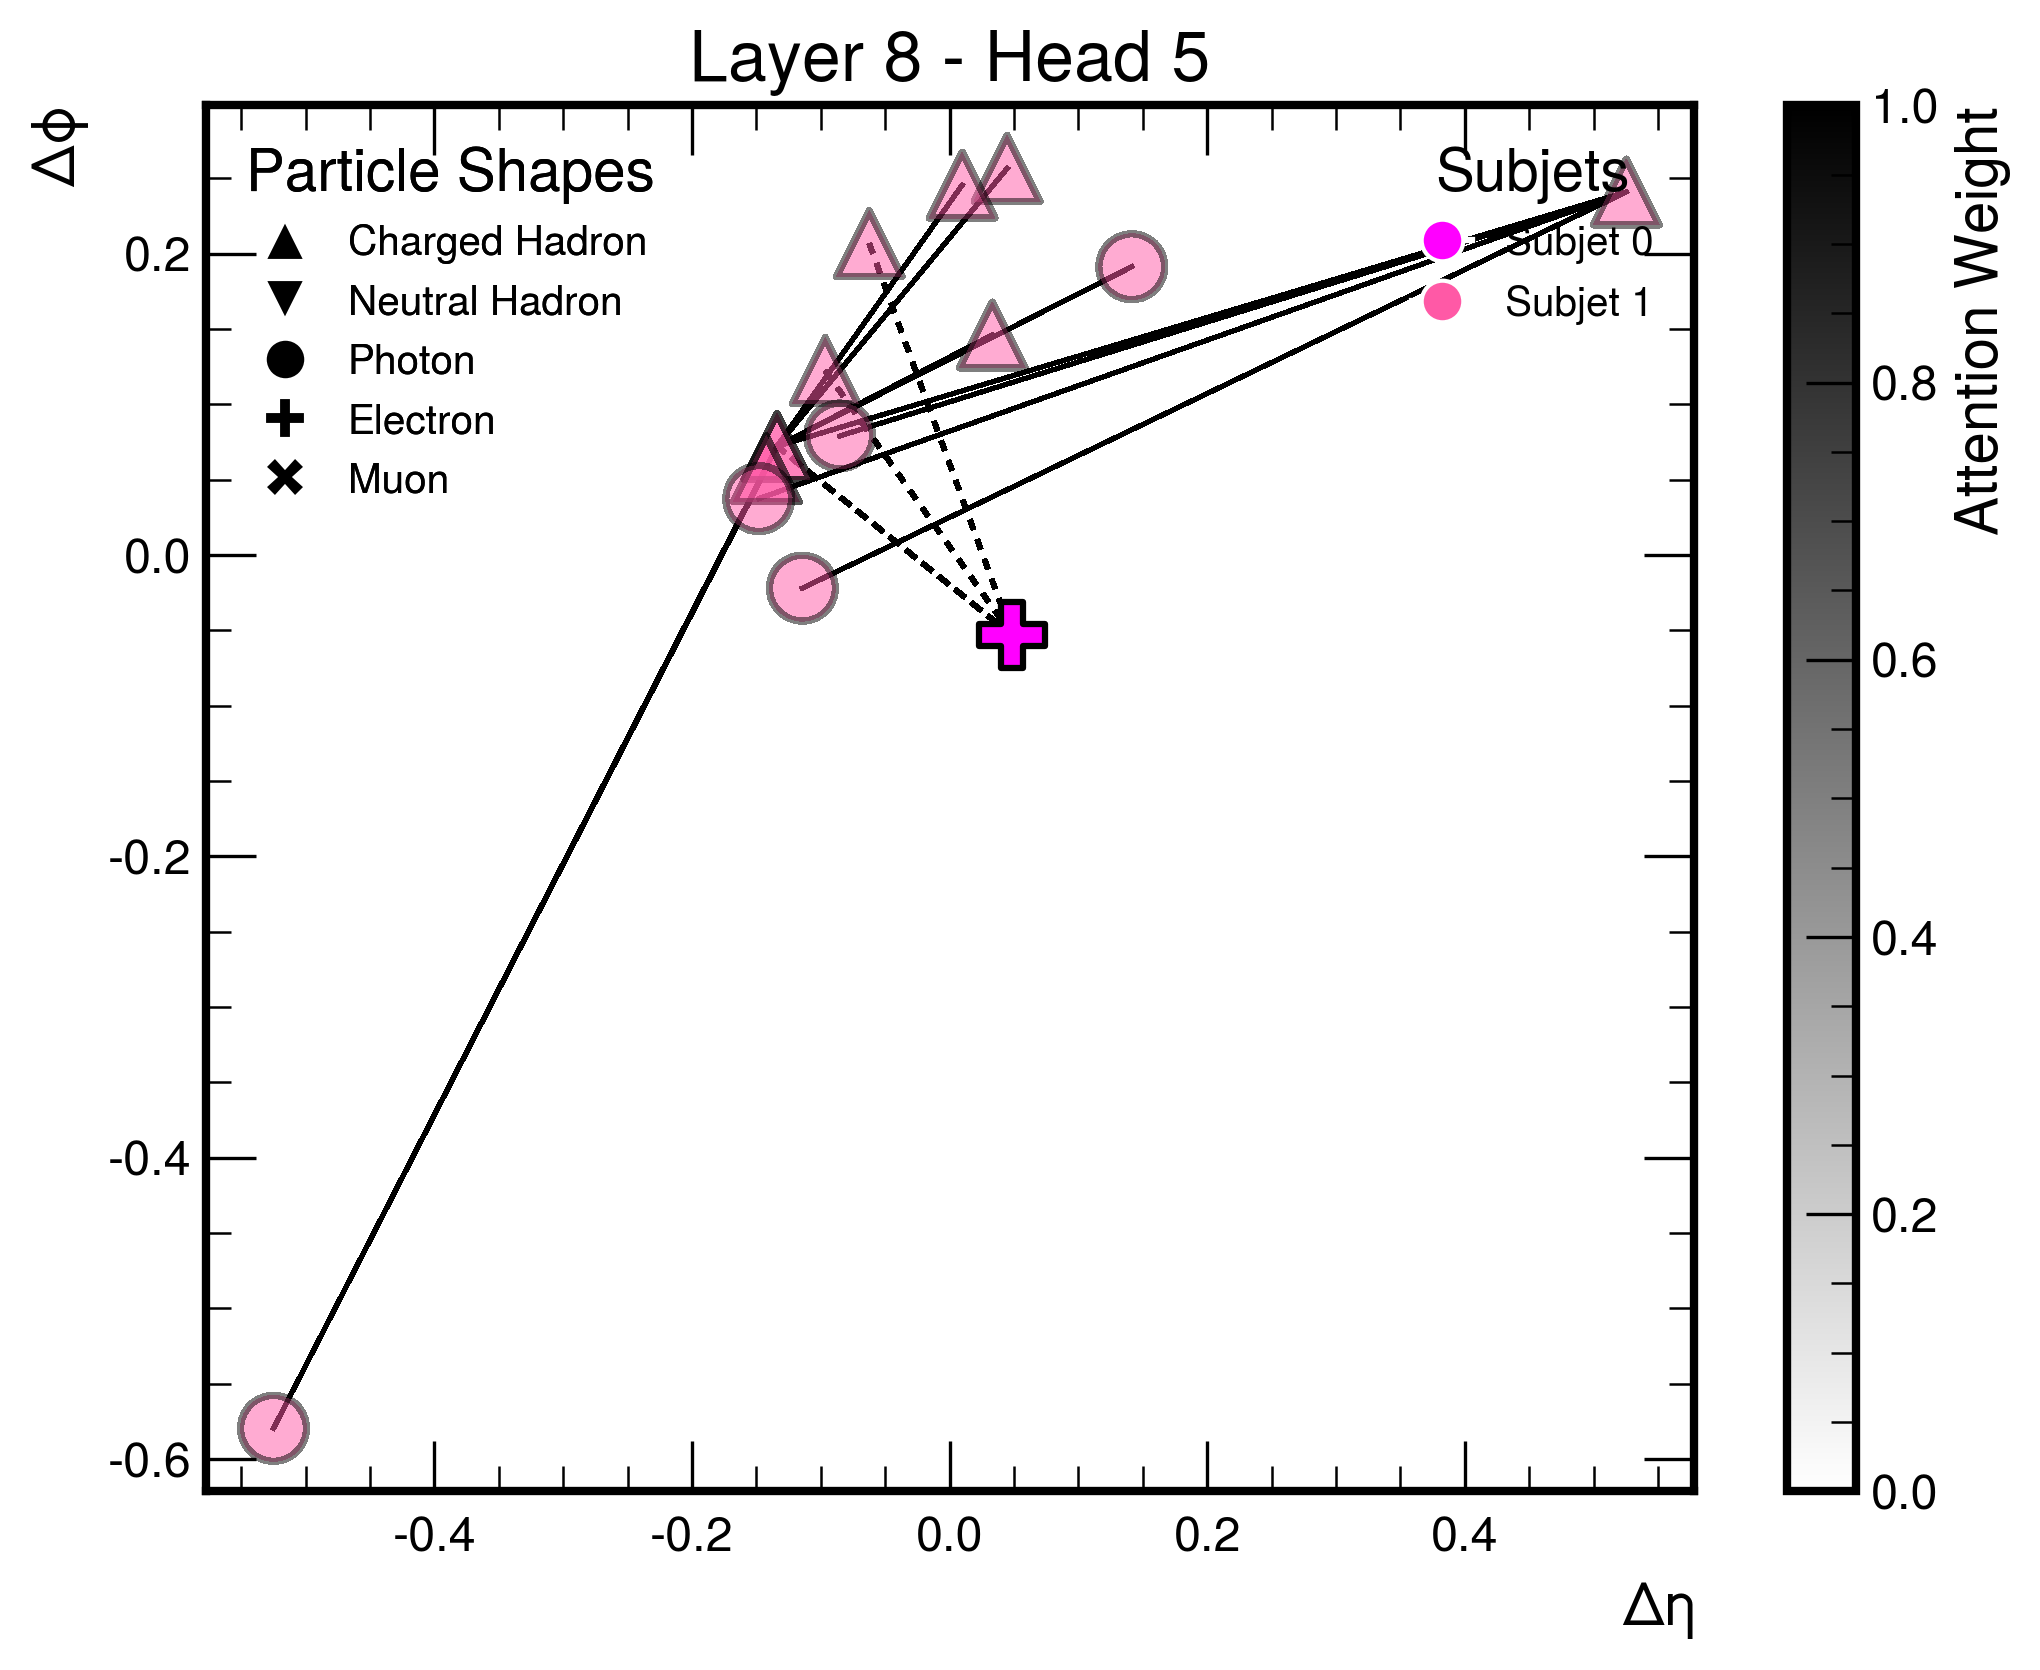

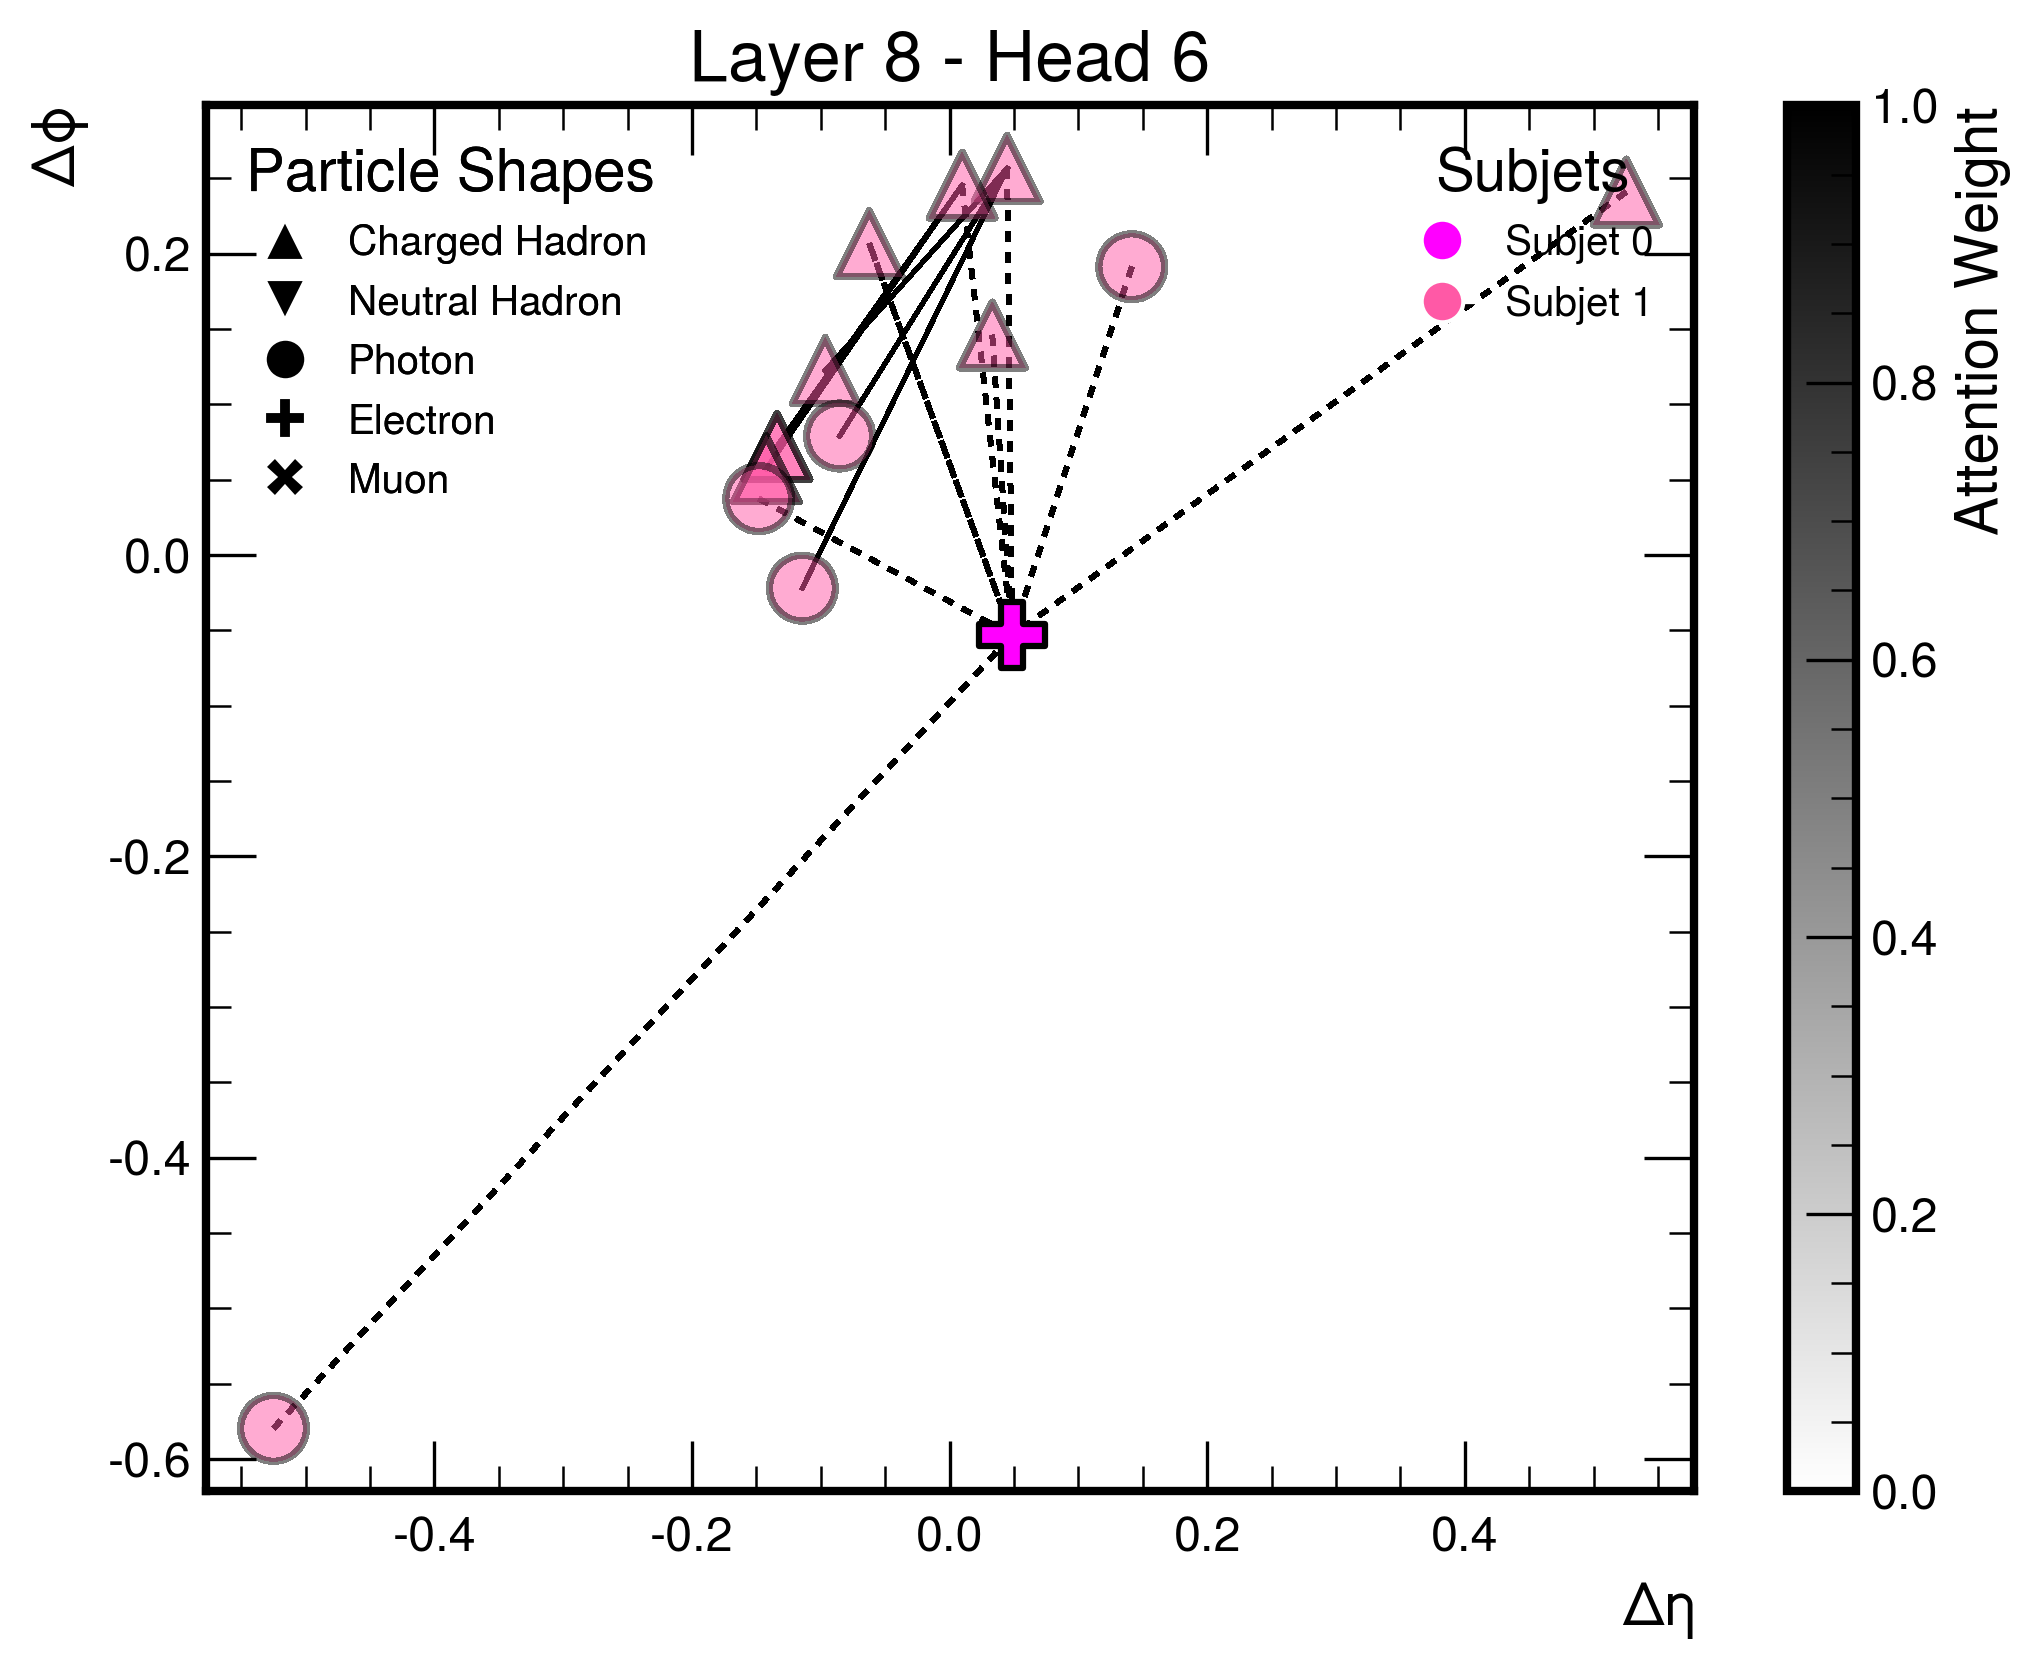

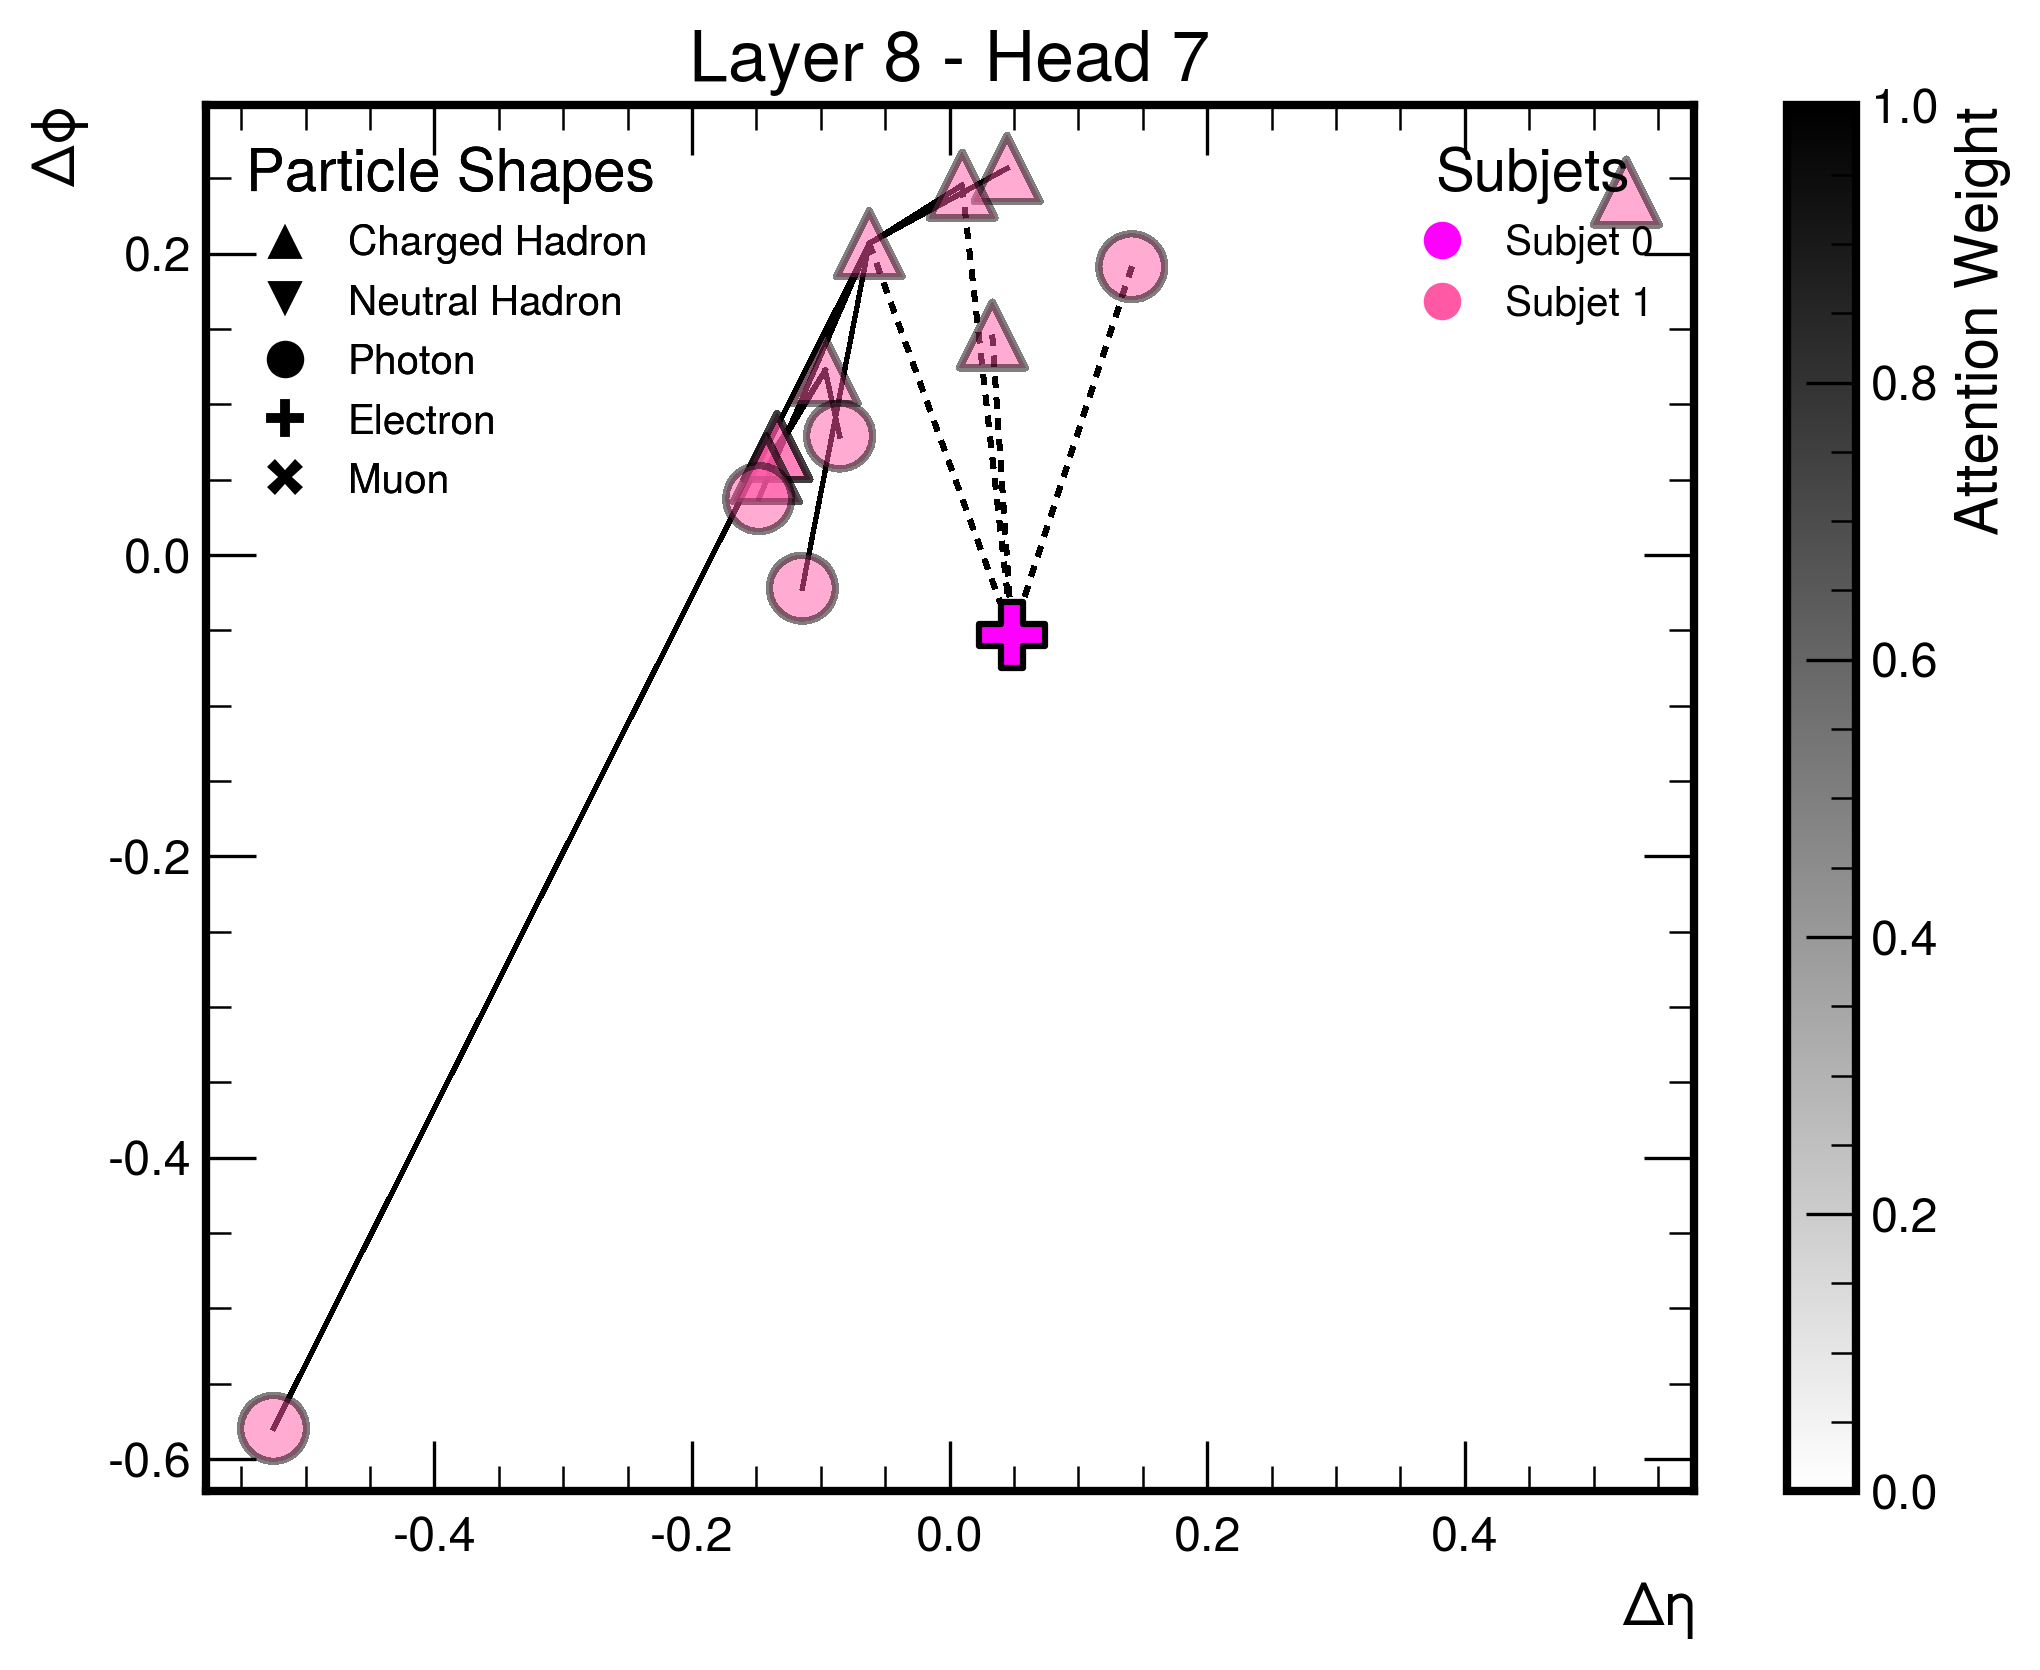

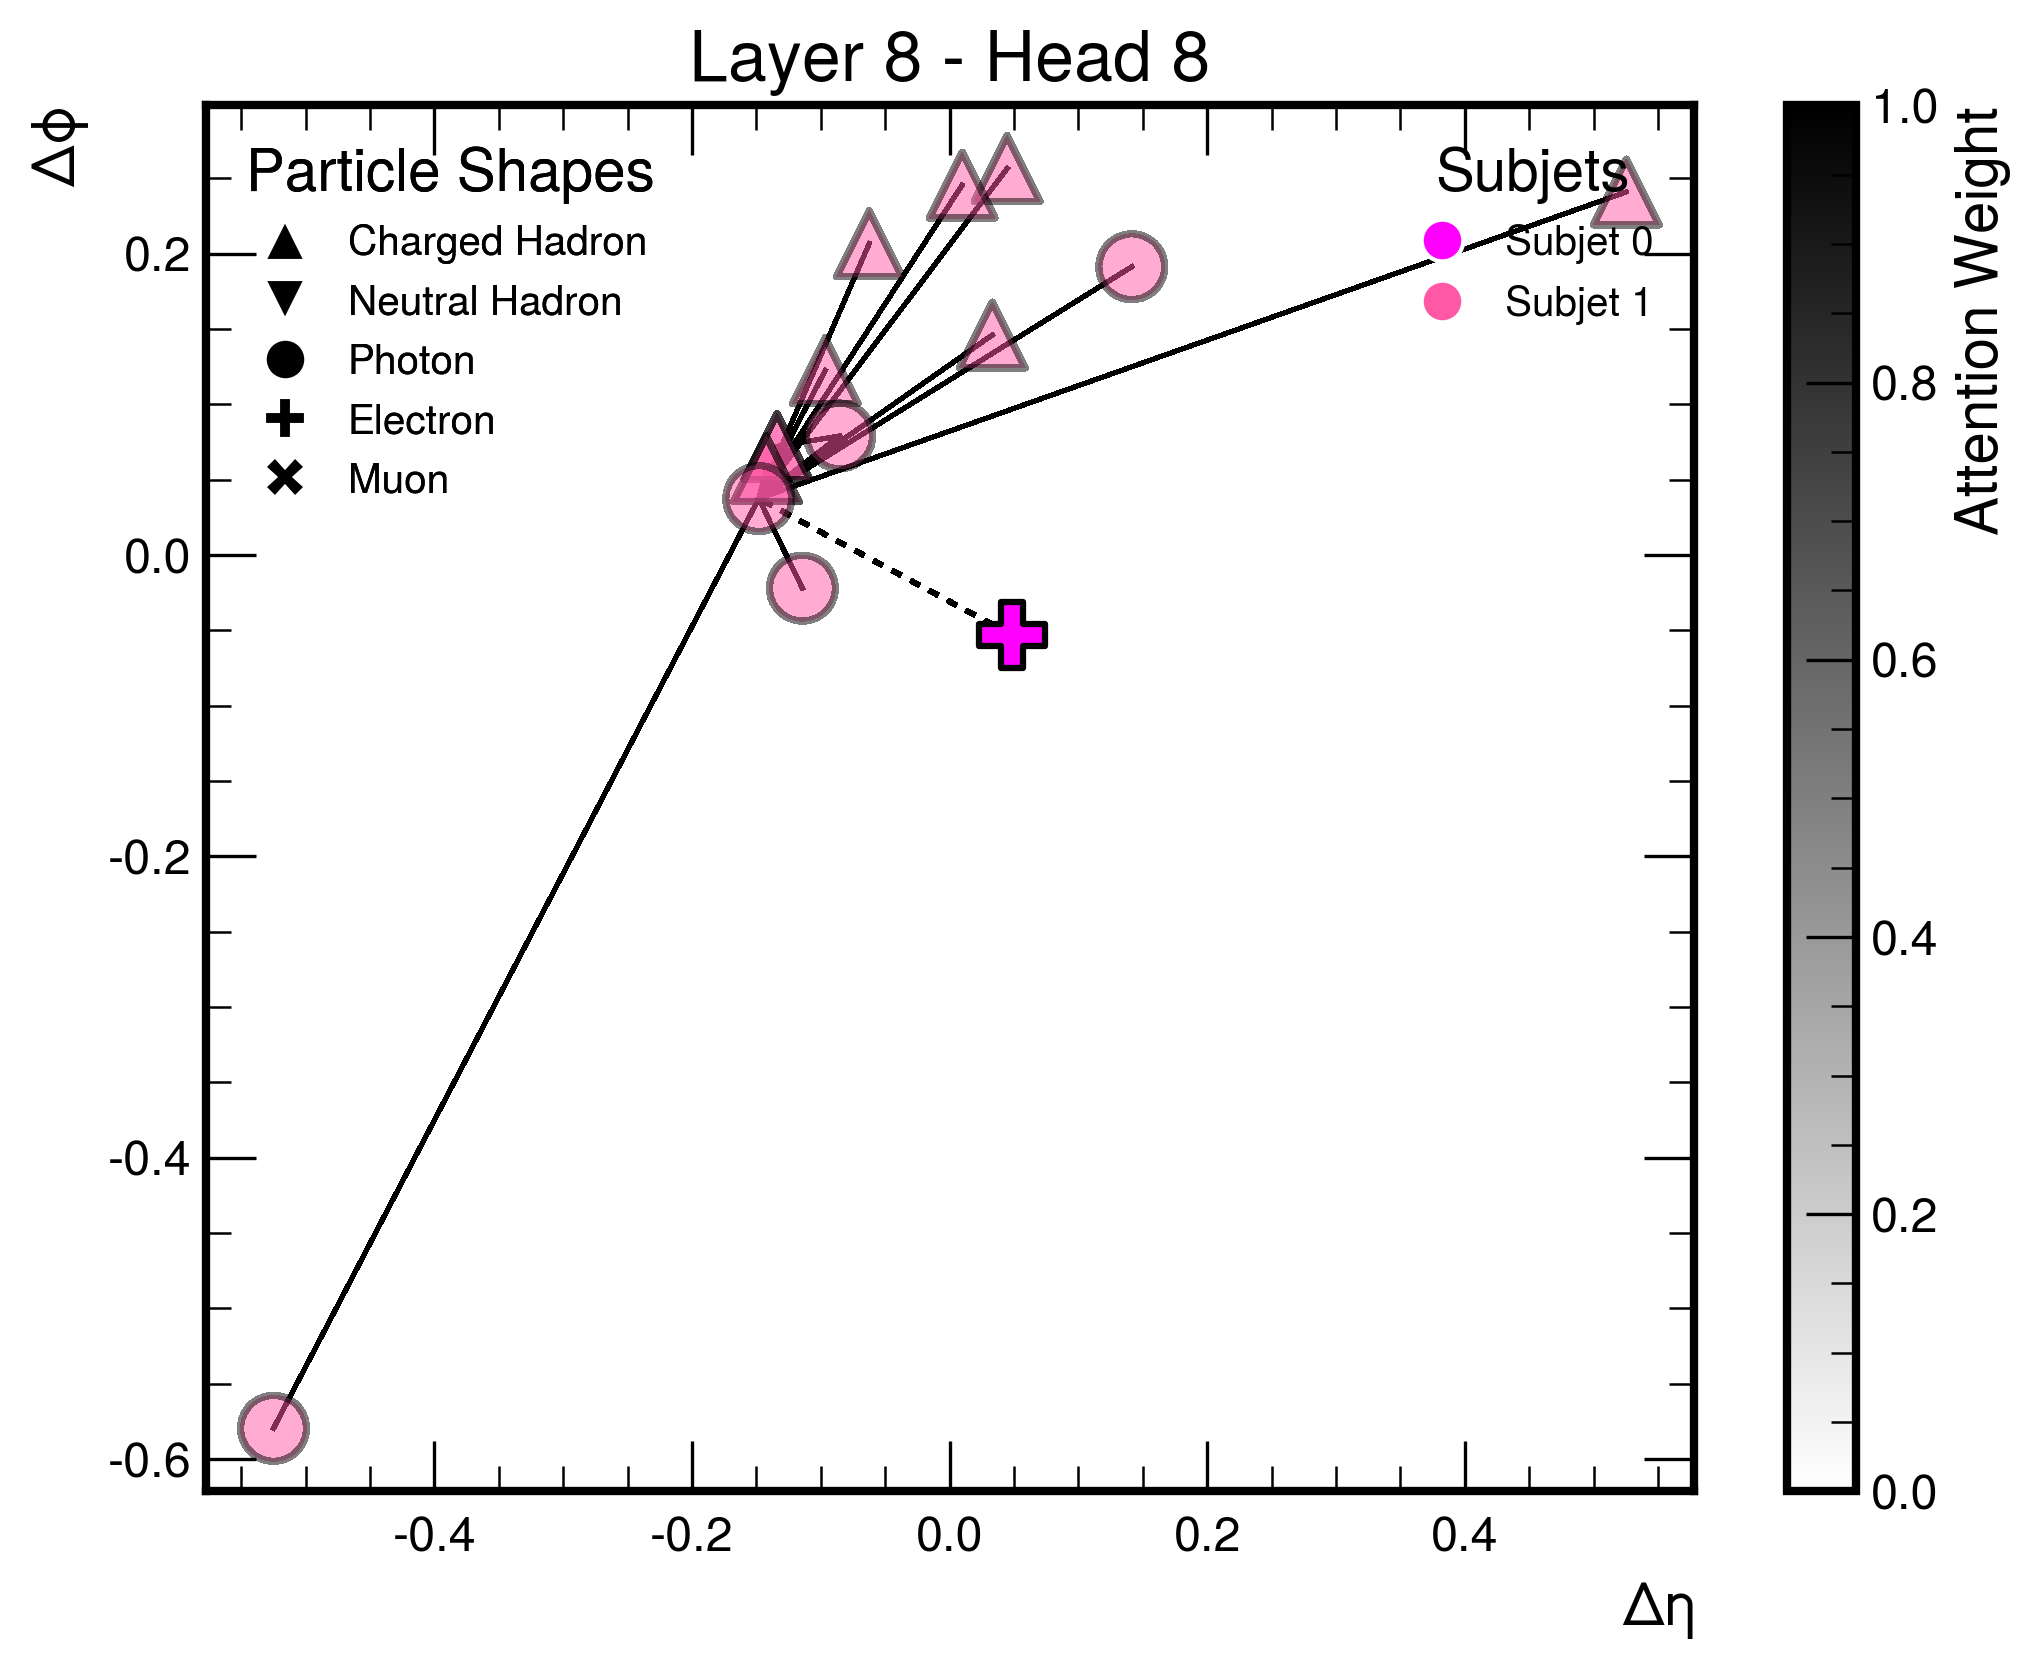

In [26]:
# Example usage based on your context (assuming pf_features, pf_mask, and attention are already defined)
jet = 1
number = jet
num = 0
for b in np.squeeze(jck_pf_mask[number]):
    if b == 0:
        break
    num += 1

# Extract the 4-momentum components for the valid particles
px = jck_pf_vectors[jet][0][0:num]
py = jck_pf_vectors[jet][1][0:num]
pz = jck_pf_vectors[jet][2][0:num]
e = jck_pf_vectors[jet][3][0:num]

# Get the subjets using the get_subjets function
subjets, subjet_vectors = get_subjets(px, py, pz, e, N_SUBJETS=2, JET_ALGO="kt")

# Initialize and combine particle data from all types
deta_all = []
dphi_all = []
pt_all = []
subjets_all = []

# Append all particle types
def append_particles(deta, dphi, pt, subjets, deta_all, dphi_all, pt_all, subjets_all):
    deta_all.extend(deta)
    dphi_all.extend(dphi)
    pt_all.extend(pt)
    subjets_all.extend(subjets)

# Process the particles and combine them into one list
append_particles(jck_pf_features[jet][5][0:num], jck_pf_features[jet][6][0:num], jck_pf_features[jet][0][0:num], subjets,
                 deta_all, dphi_all, pt_all, subjets_all)

# Convert lists to numpy arrays for plotting
deta_all = np.array(deta_all)
dphi_all = np.array(dphi_all)
pt_all = np.array(pt_all)
subjets_all = np.array(subjets_all)

# Example attention data, where `x` is the layer number
layer_number = 7  # Choose the layer
Decay = 'HToWW2Q1L'
for head_number in range(8):
  jck_plot_attention_with_particles_and_ids(jck_attention[layer_number][jet][head_number, 0:num, 0:num], jet, deta_all, dphi_all, pt_all, subjets_all, layer_number, head_number, jck_pf_features, output_filename='JetClasskin_results/attn_plots/'+str(Decay)+str(layer_number + 1) + '-head' + str(head_number + 1) + '8112025withPID.pdf')
  #plot_attention_with_particles(srandom_matrix[0][1][4, 0:num, 0:num], jet, deta_all, dphi_all, pt_all, subjets_all, layer_number, head_number, pf_features, '/content/drive/MyDrive/networks/Plots/Jet' + str(jet) + str(Decay) + '/' + 'randomAttentionMatrix' + str(Decay) + '-layer'+str(layer_number + 1) + '-head' + str(head_number + 1) + '.pdf')


In [37]:
print(qg_jet_num)

33


In [ ]:
plot_attention(
    detaCH, dphiCH, ptCH,
    detaNH, dphiNH, ptNH,
    detaPhoton, dphiPhoton, ptPhoton,
    detaElectron, dphiElectron, ptElectron,
    detaMuon, dphiMuon, ptMuon,
    pf_features[jet][0][0:num],  # Assuming this corresponds to `pt`
    deta, dphi,
    attention[x][jet][:,0:num,0:num],  # attention matrix
    8,  # layer number
    subjets[0][0:num],  # subjets
    plot_single_head=True,  # Plot only one head
    head_to_plot=5,  # Plot the 7th head (index 6)
    show_subjet=None  # Show all subjets
)


In [ ]:
plot_attention(detaCH, dphiCH, ptCH, detaNH, dphiNH, ptNH,
                   detaPhoton, dphiPhoton, ptPhoton,
                   detaElectron, dphiElectron, ptElectron,
                   detaMuon, dphiMuon, ptMuon,
                   pt, deta, dphi, attention_matrix, layer_number, subjets,
                   plot_single_head=False, head_to_plot=0, show_subjet=None)


In [ ]:
for x in range(8):
    plot_attention(detaCH,detaNH, detaPhoton,detaElectron,detaMuon, dphiCH,dphiNH,dphiPhoton,dphiElectron,dphiMuon,ptCH,ptNH,ptPhoton,ptElectron,ptMuon, pf_features[jet][0][0:num], deta, dphi,attention[x][jet][:,0:num,0:num],subjets[0][0:num])

In [ ]:
for x in range(8):
    plot_attention(detaCH,detaNH, detaPhoton,detaElectron,detaMuon, dphiCH,dphiNH,dphiPhoton,dphiElectron,dphiMuon,ptCH,ptNH,ptPhoton,ptElectron,ptMuon, pf_features[jet][0][0:num], deta, dphi,  F.softmax(torch.from_numpy(attentionOnly[x][jet][:,0:num,0:num]), dim=2) ,subjets[0][0:num])

In [ ]:
import numpy as np

# Example tensor
# attention[x][jet] could be a list of attention matrices, so we need to stack them
attention_matrices = attention
attention_array = np.stack(attention_matrices)
print(attention_array.shape)
# Compute the average across all layers
# The axis=0 means we are averaging across the first dimension (layers)
average_attention = np.mean(attention_array, axis=0)
print(average_attention.shape)

In [ ]:
average_attention[jet][:,0:num,0:num].shape

In [ ]:
plot_pre_averaged_attention(detaCH, detaNH, detaPhoton, detaElectron, detaMuon,
                       dphiCH, dphiNH, dphiPhoton, dphiElectron, dphiMuon,
                       ptCH, ptNH, ptPhoton, ptElectron, ptMuon,
                       pf_features[jet][0][0:num], deta, dphi, average_attention[jet][:,0:num,0:num], subjets[0], 'Head ')

In [ ]:
import numpy as np


attention_matrices = attention
attention_array = np.stack(attention_matrices)
print(attention_array.shape)

average_attention = np.mean(attention_array, axis=2)
average_attention = np.transpose(average_attention, [1,0,2,3])

print(average_attention.shape)

In [ ]:
plot_pre_averaged_attention(detaCH, detaNH, detaPhoton, detaElectron, detaMuon,
                       dphiCH, dphiNH, dphiPhoton, dphiElectron, dphiMuon,
                       ptCH, ptNH, ptPhoton, ptElectron, ptMuon,
                       pf_features[jet][0][0:num], deta, dphi, average_attention[jet][:,0:num,0:num], subjets[0],'Layer ')

In [ ]:
interaction[jet][:,0:num,0:num].shape

In [ ]:
import torch.nn.functional as F

softmaxed_interaction = F.softmax((interaction[jet][:,0:num,0:num]), dim = 2)

In [ ]:
plot_attention(detaCH,detaNH, detaPhoton,detaElectron,detaMuon, dphiCH,dphiNH,dphiPhoton,dphiElectron,dphiMuon,ptCH,ptNH,ptPhoton,ptElectron,ptMuon, pf_features[jet][0][0:num], deta, dphi,  softmaxed_interaction, 2, subjets[0])

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_attention_pca(attention_matrix):
    firstComponents = []

    for layerNum in range(8):
        attention_matrixes = torch.tensor(attention_matrix[layerNum][:, 0:num, 0:num])  # Replace with your actual attention matrix

        # Set up the figure and axes for plotting
        fig, axes = plt.subplots(2, 4, figsize=(16, 16))  # Make the figure more square
        axes = axes.flatten()  # Flatten to easily iterate over

        # Loop over each head (each 100x100 matrix)
        for i in range(8):
            head_matrix = attention_matrixes[i]  # Get the matrix for the i-th head

            # Convert the PyTorch tensor to a NumPy array for PCA
            head_matrix_np = head_matrix.numpy()

            # Step 1: Fit PCA
            pca = PCA(n_components=1)  # We use 1 component for the projection
            pca.fit(head_matrix_np)

            # Step 2: Get the first principal component
            first_component = pca.components_[0]  # This is a vector of length num_particles
            firstComponents.append(first_component)

            # Step 3: Project the original data onto the first principal component
            first_component_torch = torch.tensor(first_component)
            projection_scores = head_matrix @ first_component_torch  # This gives you a (num_particles,) vector

            # Step 4: Reconstruct the data using the first principal component
            reconstructed_data = torch.ger(projection_scores, first_component_torch)

            # Step 5: Apply softmax across rows or columns as needed
            softmaxed_reconstructed_data = F.softmax(reconstructed_data, dim=1)

            # Step 6: Plot the reconstructed data
            ax = axes[i]
            img = ax.imshow(softmaxed_reconstructed_data.numpy(), cmap='viridis', aspect='equal', origin='lower')  # Ensure square pixels
            fig.colorbar(img, ax=ax)

            ax.set_title(f'Layer {layerNum + 1} Head {i + 1}')

    plt.tight_layout()
    plt.show()

    return firstComponents


In [ ]:
firstCompAttention[0]

In [ ]:
atstack[jet][:,:,0:num,0:num].shape

In [ ]:
firstCompAttention = visualize_attention_pca(atstack[jet][:,:,0:num,0:num])

In [ ]:
# Step 1: Fit PCA
head_matrix = torch.tensor(atstack[jet][:,:,0:num,0:num][0][:,0:num,0:num])[0]  # Get the matrix for the i-th head

# Convert the PyTorch tensor to a NumPy array for PCA
head_matrix_np = head_matrix.numpy()
pca = PCA(n_components=1)  # We use 1 component for the projection
pca.fit(head_matrix_np)

# Step 2: Get the first principal component
projected_data = pca.fit_transform(head_matrix)

In [ ]:
firstCompAttentionOnly = visualize_attention_pca(attentionOnly.transpose(1,0,2,3,4)[96][:,:,0:num,0:num])

In [ ]:
firstCompAttention[0].shape

In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(firstCompAttention[idx], firstCompAttentionOnly[idx])
        axes[i].set_xlabel('First Component Attention')
        axes[i].set_ylabel('First Component Attention Only')
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
firstCompInteraction = visualize_attention_pca(intstack[96][:,:,0:num,0:num])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming firstCompAttention, firstCompAttentionOnly, and thirdComponent are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for layer in range(8):  # 8 layers
    fig = plt.figure(figsize=(20, 10))  # Create a new figure for each layer

    # Create a 2x4 grid for each layer
    axes = [fig.add_subplot(2, 4, i+1, projection='3d') for i in range(8)]

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create 3D scatter plot for the current index
        axes[i].scatter(firstCompAttention[idx], firstCompAttentionOnly[idx], firstCompInteraction[idx])
        axes[i].set_xlabel('First Component Attention')
        axes[i].set_ylabel('First Component Attention Only')
        axes[i].set_zlabel('First Component Interaction')
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(firstCompAttention[idx], firstCompAttentionOnly[idx])
        axes[i].set_xlabel('First Component Attention')
        axes[i].set_ylabel('First Component Interaction')
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(np.log(firstCompAttention[idx]), firstCompInteraction[idx])
        axes[i].set_xlabel('First Component Attention')
        axes[i].set_ylabel('First Component Interaction')
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(firstCompAttentionOnly[idx], firstCompInteraction[idx])
        axes[i].set_xlabel('First Component Attention Only')
        axes[i].set_ylabel('First Component Interaction')
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
np.stack(firstCompAttention).flatten().shape

In [ ]:
pf_features[jet][x,0:num].flatten()

In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for features in range(17):
  for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(firstCompAttentionOnly[idx], pf_features[96][features,0:num])
        axes[i].set_xlabel('First Component Attention Only')
        axes[i].set_ylabel('Feature ' + str(features))
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for features in range(17):
  for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(firstCompAttention[idx], pf_features[96][features,0:num])
        axes[i].set_xlabel('First Component Attention')
        axes[i].set_ylabel('Feature ' + str(features))
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
import matplotlib.pyplot as plt

# Assuming firstCompAttention and firstCompAttentionOnly are lists or arrays of length 64
# Each set of 8 entries corresponds to one layer

for features in range(17):
  for layer in range(8):  # 8 layers
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for each layer
    axes = axes.flatten()  # Flatten to easily iterate over

    for i in range(8):  # Each layer has 8 plots
        idx = layer * 8 + i  # Calculate the correct index for the current plot

        # Create scatter plot for the current index
        axes[i].scatter(firstCompInteraction[idx], pf_features[96][features,0:num])
        axes[i].set_xlabel('First Component Interaction')
        axes[i].set_ylabel('Feature ' + str(features))
        axes[i].set_title(f'Layer {layer + 1}, Head {i + 1}')

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()  # Display the plot for the current layer


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompAttentionOnly = np.array(firstCompAttentionOnly)

# Determine the size of the third dimension
third_dim_size = firstCompAttentionOnly.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompAttentionOnly.reshape(8, 8, third_dim_size)

# Average across all layers and heads for firstCompAttentionOnly
average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped, axis=(0, 1))

# Create a 5x4 grid for plotting
fig, axes = plt.subplots(4, 5, figsize=(20, 15))  # 5 columns, 4 rows
axes = axes.flatten()  # Flatten to easily iterate over

for feature_idx in range(17):  # Iterate over each feature
    # Scatter plot of the average data vs. the actual feature data
    axes[feature_idx].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, 0:num])
    axes[feature_idx].set_xlabel('Avg First Component Attention Only')
    axes[feature_idx].set_ylabel(f'Feature {feature_idx + 1}')
    axes[feature_idx].set_title(f'Feature {feature_idx + 1}')

# Adjust layout to prevent overlap and improve readability
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompAttention = np.array(firstCompAttention)

# Determine the size of the third dimension
third_dim_size = firstCompAttention.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompAttention.reshape(8, 8, third_dim_size)

# Average across all layers and heads for firstCompAttentionOnly
average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped, axis=(0, 1))

# Create a 5x4 grid for plotting
fig, axes = plt.subplots(4, 5, figsize=(20, 15))  # 5 columns, 4 rows
axes = axes.flatten()  # Flatten to easily iterate over

for feature_idx in range(17):  # Iterate over each feature
    # Scatter plot of the average data vs. the actual feature data
    axes[feature_idx].scatter(average_firstCompAttentionOnly, pf_features[jet][feature_idx, 0:num])
    axes[feature_idx].set_xlabel('Avg First Component Attention')
    axes[feature_idx].set_ylabel(f'Feature {feature_idx + 1}')
    axes[feature_idx].set_title(f'Feature {feature_idx + 1}')

# Adjust layout to prevent overlap and improve readability
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompInteraction = np.array(firstCompInteraction)

# Determine the size of the third dimension
third_dim_size = firstCompInteraction.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompInteraction.reshape(8, 8, third_dim_size)

# Average across all layers and heads for firstCompAttentionOnly
average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped, axis=(0, 1))

# Create a 5x4 grid for plotting
fig, axes = plt.subplots(4, 5, figsize=(20, 15))  # 5 columns, 4 rows
axes = axes.flatten()  # Flatten to easily iterate over

for feature_idx in range(17):  # Iterate over each feature
    # Scatter plot of the average data vs. the actual feature data
    axes[feature_idx].scatter(average_firstCompAttentionOnly, pf_features[jet][feature_idx, 0:num])
    axes[feature_idx].set_xlabel('Avg First Component Interaction')
    axes[feature_idx].set_ylabel(f'Feature {feature_idx + 1}')
    axes[feature_idx].set_title(f'Feature {feature_idx + 1}')

# Adjust layout to prevent overlap and improve readability
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompInteraction = np.array(firstCompInteraction)

# Determine the size of the third dimension
third_dim_size = firstCompInteraction.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompInteraction.reshape(8, 8, third_dim_size)

# Iterate over each feature
for feature_idx in range(17):
    # Create a 2x4 grid for plotting (8 plots, one for each head)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 4 columns, 2 rows
    axes = axes.flatten()  # Flatten to easily iterate over

    for head in range(8):  # Iterate over each head
        # Average across all layers for the current head
        average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped[:, head, :], axis=0)

        # Scatter plot of the average data vs. the actual feature data
        axes[head].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, :third_dim_size])
        axes[head].set_xlabel('Avg First Component Interaction')
        axes[head].set_ylabel(f'Feature {feature_idx + 1}')
        axes[head].set_title(f'Feature {feature_idx + 1} - Head {head + 1}')

    # Adjust layout to prevent overlap and improve readability
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompAttention = np.array(firstCompAttention)

# Determine the size of the third dimension
third_dim_size = firstCompAttentionOnly_reshaped.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompAttention.reshape(8, 8, third_dim_size)

# Iterate over each feature
for feature_idx in range(17):
    # Create a 2x4 grid for plotting (8 plots, one for each head)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 4 columns, 2 rows
    axes = axes.flatten()  # Flatten to easily iterate over

    for head in range(8):  # Iterate over each head
        # Average across all layers for the current head
        average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped[:, head, :], axis=0)

        # Scatter plot of the average data vs. the actual feature data
        axes[head].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, :third_dim_size])
        axes[head].set_xlabel('Avg First Component Interaction')
        axes[head].set_ylabel(f'Feature {feature_idx + 1}')
        axes[head].set_title(f'Feature {feature_idx + 1} - Head {head + 1}')

    # Adjust layout to prevent overlap and improve readability
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompAttention = np.array(firstCompAttention)

# Determine the size of the third dimension
third_dim_size = firstCompAttentionOnly_reshaped.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompAttention.reshape(8, 8, third_dim_size)

# Iterate over each feature
for feature_idx in range(17):
    # Create a 2x4 grid for plotting (8 plots, one for each layer)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 4 columns, 2 rows
    axes = axes.flatten()  # Flatten to easily iterate over

    for layer in range(8):  # Iterate over each layer
        # Average across all heads for the current layer
        average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped[layer], axis=0)

        # Scatter plot of the average data vs. the actual feature data
        axes[layer].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, :third_dim_size])
        axes[layer].set_xlabel('Avg First Component Interaction')
        axes[layer].set_ylabel(f'Feature {feature_idx + 1}')
        axes[layer].set_title(f'Feature {feature_idx + 1} - Layer {layer + 1}')

    # Adjust layout to prevent overlap and improve readability
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompAttention = np.array(firstCompAttention)

# Determine the size of the third dimension
third_dim_size = firstCompAttentionOnly_reshaped.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompAttention.reshape(8, 8, third_dim_size)

# Iterate over each feature
for feature_idx in range(17):
    # Create a 2x4 grid for plotting (8 plots, one for each head)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 4 columns, 2 rows
    axes = axes.flatten()  # Flatten to easily iterate over

    for head in range(8):  # Iterate over each head
        # Average across all layers for the current head
        average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped[:, head, :], axis=0)

        # Scatter plot of the average data vs. the actual feature data
        axes[head].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, :third_dim_size])
        axes[head].set_xlabel('Avg First Component Interaction')
        axes[head].set_ylabel(f'Feature {feature_idx + 1}')
        axes[head].set_title(f'Feature {feature_idx + 1} - Head {head + 1}')

    # Adjust layout to prevent overlap and improve readability
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompAttentionOnly = np.array(firstCompAttentionOnly)

# Determine the size of the third dimension
third_dim_size = firstCompAttentionOnly_reshaped.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompAttentionOnly.reshape(8, 8, third_dim_size)

# Iterate over each feature
for feature_idx in range(17):
    # Create a 2x4 grid for plotting (8 plots, one for each head)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 4 columns, 2 rows
    axes = axes.flatten()  # Flatten to easily iterate over

    for head in range(8):  # Iterate over each head
        # Average across all layers for the current head
        average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped[:, head, :], axis=0)

        # Scatter plot of the average data vs. the actual feature data
        axes[head].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, :third_dim_size])
        axes[head].set_xlabel('Avg First Component Interaction')
        axes[head].set_ylabel(f'Feature {feature_idx + 1}')
        axes[head].set_title(f'Feature {feature_idx + 1} - Head {head + 1}')

    # Adjust layout to prevent overlap and improve readability
    plt.tight_layout()
    plt.show()
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array if it's not already
firstCompInteraction = np.array(firstCompInteraction)

# Determine the size of the third dimension
third_dim_size = firstCompInteraction.size // (8 * 8)  # Calculate the size of the third dimension

# Reshape to (layers, heads, third_dim_size)
firstCompAttentionOnly_reshaped = firstCompInteraction.reshape(8, 8, third_dim_size)

# Iterate over each feature
for feature_idx in range(17):
    # Create a 2x4 grid for plotting (8 plots, one for each head)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 4 columns, 2 rows
    axes = axes.flatten()  # Flatten to easily iterate over

    for head in range(8):  # Iterate over each head
        # Average across all layers for the current head
        average_firstCompAttentionOnly = np.mean(firstCompAttentionOnly_reshaped[:, head, :], axis=0)

        # Scatter plot of the average data vs. the actual feature data
        axes[head].scatter(average_firstCompAttentionOnly, pf_features[96][feature_idx, :third_dim_size])
        axes[head].set_xlabel('Avg First Component Interaction')
        axes[head].set_ylabel(f'Feature {feature_idx + 1}')
        axes[head].set_title(f'Feature {feature_idx + 1} - Head {head + 1}')

    # Adjust layout to prevent overlap and improve readability
    plt.tight_layout()
    plt.show()
